In [11]:
# Standard modules
import sys
import os
import glob

# 3rd party modules
from datetime import timedelta
import xarray as xr
import numpy as np
from scipy import integrate
from scipy import stats
from scipy import signal
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import cmocean




# we add our 'cesm_tools' directory to pythons look-up path
# then we can import python files using the 'import command'
#sys.path.insert(0, "/home/slingbeek/scripts/cesm_tools/")
#import cesm_scenarios2 # 'cesm_scenarios' contains the 'Scenario' class

# to suppress annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
save = False
imgsize1 = (7.48,2.5)
imgsize2 = (3.74,6)
imgsize3 = (7.48,4)
imgsize4 = (7.48,4.5)
imgsize5 = (7.48,6)
imgsize6 = (7.48,8)

# savepath = '/home/slingbeek/git_map/MScThesis/Paper_imgs/'
savepath = '/home/jasperdj/CESM-CAM_SAI/results/paper_imgs/'
if not os.path.exists(savepath):
    os.mkdir(savepath)

plt.rcParams.update({'font.size': 8})
plt.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth
plt.rcParams['figure.dpi'] = 300

slice_i = slice('2016','2035')
slice_f = slice('2080','2099')

In [8]:
def open_mfdataset(filepaths: list[str], ncstore_dir: str='~/kerchunk', **kwargs):
    """a faster alternative to xr.open_mfdataset using kerchunk
    
    This function uses kerchunk to create an NC_STORE reference file,
    that instructs the program how to read the netCDF files efficiently. 
    Coordinates must be consistent throughout all files.
    The NC_STORE is saved after first use, and will be read on each 
    subsequent usage of this function.
    
    Parameters:
    filepaths : str or list[str]
        (list of) netCDF file names, may contain wild cards
    ncstore_dir: Pathlike
        Path where NC_STORE reference files will be saved
    kwargs: dict
        any additional keyword arguments are passed on to xr.open_dataset
        
    Returns: xr.Dataset
        a Dataset instance containing all the netCDF data
        
    v0.0
    """
    
    # make sorted list of absolute filepaths
    if isinstance(filepaths, str):
        filepaths = glob.glob(filepaths)
    filepaths = sorted([os.path.abspath(fp) for fp in filepaths])
    if len(filepaths) == 1: # use xr.open_dataset directly if there is one file
        return xr.open_dataset(filepaths[0], **kwargs)
    
    # set default keyword arguments for xr.open_dataset on NC_STORE file
    default_kw = {'engine':'kerchunk', 'storage_options':{'target_protocol':'file'}}
    for (k,v) in default_kw.items():
        if k in kwargs:
            print(f'open_mfdataset(): ignoring keyword {k}')
        kwargs[k] = v
    
    # create NC_STORE filename from netCDF filename, including timestamp
    # of first and last file. Open and return dataset if the file already exists
    ncstore_dir = os.path.expanduser(ncstore_dir)
    timestr = lambda i: os.path.basename(filepaths[i]).split('.')[-2] # timestamp
    ncstorefile = (os.path.basename(filepaths[0])
                   .replace(timestr(0),f"{timestr(0)}_{timestr(-1)}")
                   .replace('.nc','.json'))
    ncstore_path = os.path.join(ncstore_dir, ncstorefile)
    if not os.path.exists(ncstore_dir):
        os.mkdir(ncstore_dir)
    elif os.path.exists(ncstore_path):
        print(f"Reading combined kerchunk reference file {ncstore_path}")
        return xr.open_dataset(ncstore_path, **kwargs)
    
    # make new NC_STORE data
    filebag = dask.bag.from_sequence(filepaths, npartitions=None)
    reffiles = (filebag.map(NetCDF3ToZarr, inline_threshold=0, max_chunk_size=0)
                .map(lambda z: z.translate()).compute())
    mzz = MultiZarrToZarr(reffiles, concat_dims=['time'], coo_map={'time':'cf:time'})
    
    # write NC_STORE data and return opened dataset
    with open(f"{ncstore_path}", "wb") as f:
       print(f"Writing combined kerchunk reference file {ncstore_path}")
       f.write(json.dumps(mzz.translate()).encode())
    
    return xr.open_dataset(ncstore_path, **kwargs)

# Load CAM data

In [3]:
# # Meta data
# cases_cnt = {'b.e21.BSSP585cmip6.f09_g17.control.01': {'directory': '/home/slingbeek/cesm2_data/monthly','years': np.arange(2015,2100)}}
# cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': '/home/slingbeek/cesm2_data/monthly','years': np.arange(2020,2045)},
#                'b.e21.BSSP585cmip6.f09_g17.2020feedback.02': {'directory': '/home/slingbeek/cesm2_data/monthly','years': np.arange(2045,2100)}}

# cases = [cases_cnt, cases_sai20]
# scenario_names = ['Control', 'SAI 2020'] 

# # Define dictionary
# scenarios = {name: cesm_scenarios2.Scenario(name,case) for name, case in zip(scenario_names,cases)}


In [6]:
# CAM output files
FILES = {
    'Control': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.06/atm/hist/*.h0.*.nc")),
    'SAI 2020': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01/atm/hist/*.h0.*.nc"))[0:300] # 2020-2044
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/atm/hist/*.h0.*.nc"))[:-12] # 2045-2099
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/atm/hist/*.h0.*.nc")), # 2100-2130
    'SAI 2080': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/atm/hist/*.h0.*.nc"))
}

In [12]:
# open CAM output files
scenarios = {k:open_mfdataset(v, chunks={'time':1}) for k,v in FILES.items()}
for exp in scenarios:
    scenarios[exp] = scenarios[exp].assign_coords({'time':('time',(scenarios[exp].time-timedelta(days=15,hours=12)).data,scenarios[exp].time.attrs)})

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.2015-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.2020-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01.cam.h0.2100-01_2099-12.json


# Load WACCM data

In [14]:
def CMIP6_get_var(var):
    return xr.open_dataset('/home/jasperdj/simone/CMIP6/'+var+'/'+var+'.Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc')

In [23]:
def GLENS2_get_var(var):
    pt1 = xr.open_dataset('/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.'+var+'.207001-207912.nc')
    pt2 = xr.open_dataset('/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.'+var+'.208001-208912.nc')
    pt3 = xr.open_dataset('/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.'+var+'.209001-210012.nc')

    time1 = ('time', pt1.time_bnds.mean('nbnd').data, pt1.time.attrs)
    time2 = ('time', pt2.time_bnds.mean('nbnd').data, pt2.time.attrs)
    time3 = ('time', pt3.time_bnds.mean('nbnd').data, pt3.time.attrs)

    pt1 = pt1.assign_coords({'time1':time1}).swap_dims({'time':'time1'}).drop_vars('time').rename({'time1':'time'})
    pt2 = pt2.assign_coords({'time2':time2}).swap_dims({'time':'time2'}).drop_vars('time').rename({'time2':'time'})
    pt3 = pt3.assign_coords({'time3':time3}).swap_dims({'time':'time3'}).drop_vars('time').rename({'time3':'time'})
    return xr.concat((pt1,pt2,pt3),dim='time')
    

# Handy functions 'n' stuff

In [6]:
def surf_mean(field):
    weights = np.cos(np.deg2rad(field.lat))
    weighted = field.weighted(weights)
    return weighted.mean(('lon','lat'))

In [7]:
def time_mean(field,time_slice):
    ds = field.sel(time=time_slice)
    ds['tw'] = (ds.time_bnds[:,1].astype("datetime64[ns]") - ds.time_bnds[:,0].astype("datetime64[ns]")).dt.days
    return ds.weighted(ds.tw).mean('time', keep_attrs=True).drop('tw')

In [8]:
# def time_mean2(field,time_slice,var):
#     ds = field.sel(time=time_slice)
#     weights = (np.roll(ds.time_bnds[:,0].astype("datetime64[ns]"), shift=-1) - ds.time_bnds[:,0].astype("datetime64[ns]")).dt.days
#     weights[-1] = weights[11]
#     return ds[var].weighted(weights).mean('time', keep_attrs=True)

In [9]:
def time_mean3(field,time_slice,var):
    ds = field.sel(time=time_slice)
    weights = (ds.time_bnds[:,1].astype("datetime64[ns]") - ds.time_bnds[:,0].astype("datetime64[ns]")).dt.days
    return ds[var].weighted(weights).mean('time', keep_attrs=True)

In [10]:
def to_monthly(ds):
    year = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")

In [11]:
def T0_func(ds):
    psi = np.deg2rad(ds.lat)
    A = integrate.simpson(y=np.cos(psi), x=psi)
    L0 = ds.mean(dim='lon')*np.cos(psi)
    T0 = (1/A) * integrate.simpson(y=L0, x=psi)
    return T0

In [12]:
def T1_func(ds):
    psi = np.deg2rad(ds.lat)
    A = integrate.simpson(y=np.cos(psi), x=psi)
    L1 = ds.mean(dim='lon')*np.sin(psi)*np.cos(psi)
    T1 = (1/A) * integrate.simpson(y=L1, x=psi)
    return T1

In [13]:
def T2_func(ds):
    psi = np.deg2rad(ds.lat)
    A = integrate.simpson(y=np.cos(psi), x=psi)
    L2 = ds.mean(dim='lon')*(1/2)*(3*np.sin(psi)**2-1)*np.cos(psi)
    T2 = (1/A) * integrate.simpson(y=L2, x=psi)
    return T2

In [14]:
p_ref = 100000
cp = 1004
Rdry = 286.9
kappa = Rdry/cp

def theta(ds):
    return ds.T*(p_ref/ds.plev)**kappa

def theta2(ds, var):
    return ds[var]*(p_ref/ds.plev)**kappa


In [15]:
C_ref = ['C_ref', 'CJJA_ref', 'CDJF_ref']
W_ref = ['W_ref', 'WJJA_ref', 'WDJF_ref']
C_20 = ['C_20', 'CJJA_20', 'CDJF_20']
W_20 = ['W_20', 'WJJA_20', 'WDJF_20']
C_cnt = ['C_cnt', 'CJJA_cnt', 'CDJF_cnt']
W_cnt = ['W_cnt', 'WJJA_cnt', 'WDJF_cnt']

C_20ref = ['C_20ref', 'CJJA_20ref', 'CDJF_20ref']
W_20ref = ['W_20ref', 'WJJA_20ref', 'WDJF_20ref']

C_cntref = ['C_cntref', 'CJJA_cntref', 'CDJF_cntref']
W_cntref = ['W_cntref', 'WJJA_cntref', 'WDJF_cntref']

C_20cnt = ['C_20cnt', 'CJJA_20cnt', 'CDJF_20cnt']
W_20cnt = ['W_20cnt', 'WJJA_20cnt', 'WDJF_20cnt']

CW2 = ['CW', 'CWJJA', 'CWDJF']

C_zma = ['C', 'CJJA', 'CDJF']
W_zma = ['W', 'WJJA', 'WDJF']

CW = ['CWref', 'CWcnt', 'CW20']


# Temperature gradients

## Data

In [16]:
scenarios['Control'].get_atm_var2('TREFHT')
scenarios['SAI 2020'].get_atm_var2('TREFHT')
trefht_C_c = scenarios['Control']['TREFHT']['TREFHT']
trefht_C_20 = scenarios['SAI 2020']['TREFHT']['TREFHT']

trefht_W_c = CMIP6_get_var('tas')['tas']
trefht_W_20_1 = xr.open_dataset('/home/slingbeek/GLENS2/monthly/TREFHT/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.TREFHT.201901-206812.nc')
trefht_W_20_2 = xr.open_dataset('/home/slingbeek/GLENS2/monthly/TREFHT/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.TREFHT.206901-210012.nc')
trefht_W_20 = xr.concat((trefht_W_20_1, trefht_W_20_2), dim='time')['TREFHT']

scen_t = ['W_c', 'W_20', 'C_c', 'C_20']
deltas = ['W_cref', 'W_20ref', 'C_cref', 'C_20ref']

tfull = {
    'C_c':trefht_C_c,
    'C_20':trefht_C_20,
    'W_c':trefht_W_c,
    'W_20':trefht_W_20
}


In [17]:
time_dict = {}
for i in range(len(deltas)):
    time_dict[deltas[i]] = tfull[scen_t[i]].groupby('time.year').mean(dim='time').year

In [18]:
### T0 - GMST compared to 2020
T0 = {}
for i in scen_t:
    T0[i] = T0_func(tfull[i].groupby('time.year').mean(dim='time'))

deltaT0 = {
    'C_cref':T0['C_c']- np.mean(T0['C_c'][0:10]),
    'C_20ref':T0['C_20'] - np.mean(T0['C_c'][0:10]),
    'W_cref':T0['W_c']- np.mean(T0['W_c'][0:10]),
    'W_20ref':T0['W_20'] - np.mean(T0['W_c'][0:10])
}
    

In [19]:
### T1 - Interhemispheric temperature
T1 = {}
for i in scen_t:
    T1[i] = T1_func(tfull[i].groupby('time.year').mean(dim='time'))

deltaT1 = {
    'C_cref':T1['C_c']- np.mean(T1['C_c'][0:10]),
    'C_20ref':T1['C_20'] - np.mean(T1['C_c'][0:10]),
    'W_cref':T1['W_c']- np.mean(T1['W_c'][0:10]),
    'W_20ref':T1['W_20'] - np.mean(T1['W_c'][0:10])
}

In [20]:
### T2 - equator-to-pole temperature 
T2 = {}
for i in scen_t:
    T2[i] = T2_func(tfull[i].groupby('time.year').mean(dim='time'))

deltaT2 = {
    'C_cref':T2['C_c']- np.mean(T2['C_c'][0:10]),
    'C_20ref':T2['C_20'] - np.mean(T2['C_c'][0:10]),
    'W_cref':T2['W_c']- np.mean(T2['W_c'][0:10]),
    'W_20ref':T2['W_20'] - np.mean(T2['W_c'][0:10])
}

In [32]:
var1C =  np.var(deltaT1['C_cref'])
print(var1C)
var1C =  np.var(deltaT1['W_cref'])
print(var1C)
var1C =  np.var(deltaT2['C_cref'])
print(var1C)
var1C =  np.var(deltaT2['W_cref'])
print(var1C)

var1C =  np.var(deltaT1['C_20ref'])
print(var1C)
var1C =  np.var(deltaT1['W_20ref'])
print(var1C)
var1C =  np.var(deltaT2['C_20ref'])
print(var1C)
var1C =  np.var(deltaT2['W_20ref'])
print(var1C)

0.010071192139391777
0.016584458616982645
0.011036288989840812
0.017509790890049132
0.003566580047588943
0.0778893672240593
0.0024818055709732506
0.002918800312681923


In [27]:
ttest1 = stats.ttest_ind(deltaT1['C_cref'], deltaT1['W_cref'])
ttest2 = stats.ttest_ind(deltaT2['C_cref'], deltaT2['W_cref'])

print(ttest1, ttest2)

ttest12 = stats.ttest_ind(deltaT1['C_20ref'], deltaT1['W_20ref'])
ttest22 = stats.ttest_ind(deltaT2['C_20ref'], deltaT2['W_20ref'])

print(ttest12, ttest22)


def func(x,a,b):
    return a*x + b

popt1C,pcov1C = curve_fit(func, time_dict['C_cref']-2020,deltaT1['C_cref'])
popt1W,pcov1W = curve_fit(func, time_dict['W_cref']-2020,deltaT1['W_cref'])
popt2C,pcov2C = curve_fit(func, time_dict['C_cref']-2020,deltaT2['C_cref'])
popt2W,pcov2W = curve_fit(func, time_dict['W_cref']-2020,deltaT2['W_cref'])

print(popt1C)
print(np.sqrt(pcov1C[0,0]), np.sqrt(pcov1C[1,1]))

print(popt1W)
print(np.sqrt(pcov1W[0,0]), np.sqrt(pcov1W[1,1]))

print(popt2C)
print(np.sqrt(pcov2C[0,0]), np.sqrt(pcov2C[1,1]))

print(popt2W)
print(np.sqrt(pcov2W[0,0]), np.sqrt(pcov2W[1,1]))

popt1C,pcov1C = curve_fit(func, time_dict['C_20ref']-2020,deltaT1['C_20ref'])
popt1W,pcov1W = curve_fit(func, time_dict['W_20ref']-2020,deltaT1['W_20ref'])
popt2C,pcov2C = curve_fit(func, time_dict['C_20ref']-2020,deltaT2['C_20ref'])
popt2W,pcov2W = curve_fit(func, time_dict['W_20ref']-2020,deltaT2['W_20ref'])

print(popt1C)
print(np.sqrt(pcov1C[0,0]), np.sqrt(pcov1C[1,1]))

print(popt1W)
print(np.sqrt(pcov1W[0,0]), np.sqrt(pcov1W[1,1]))

print(popt2C)
print(np.sqrt(pcov2C[0,0]), np.sqrt(pcov2C[1,1]))

print(popt2W)
print(np.sqrt(pcov2W[0,0]), np.sqrt(pcov2W[1,1]))

TtestResult(statistic=-1.9070570695440068, pvalue=0.058209611659134804, df=169.0) TtestResult(statistic=-1.7775814336192757, pvalue=0.0772710645667253, df=169.0)
TtestResult(statistic=2.04247704475611, pvalue=0.04273541495978136, df=161.0) TtestResult(statistic=2.879572359012556, pvalue=0.004524064930346989, df=161.0)
[0.00339544 0.02208369]
0.00025031442996526897 0.011112946002398446
[ 0.00486383 -0.00078264]
0.00019685314966332964 0.00885292479449391
[0.00391574 0.00179368]
0.00019010752177689276 0.008440003545960452
[ 0.00502745 -0.0091592 ]
0.0001932863742419903 0.00869251635848846
[-0.00067792  0.05548463]
0.0002825888875922955 0.012929792774639662
[-0.00226457  0.0537639 ]
0.0012696237327225347 0.05919769566467151
[-0.00104812  0.06099048]
0.00021350422234038088 0.009768838974727728
[-0.00050996  0.01638082]
0.00024406425653920928 0.011379782266976644


## Plot

In [69]:
# cols = ['firebrick', 'navy', 'coral', 'dodgerblue']
# labels = ['CAM-Control', 'CAM-SAI 2020', 'WACCM-Control', 'WACCM-SAI 2020']

# fig, axs = plt.subplots(3,1, sharex=True, figsize=imgsize2, layout='constrained')

# for i in range(len(deltas)):
#     axs[0].plot(time_dict[deltas[i]], deltaT0[deltas[i]], label=labels[i], color=cols[i], linewidth=1.3)

# axs[0].set_ylabel(r'$\Delta$T$_0$ [K]')
# axs[0].legend()
# axs[0].grid()
# axs[0].set_ylim(-0.5,5.5)
# axs[0].set_xlim(2015,2100)


# for i in range(len(deltas)):
#     axs[1].plot(time_dict[deltas[i]], deltaT1[deltas[i]], color=cols[i], linewidth=1.3)

# axs[1].set_ylabel(r'$\Delta$T$_1$ [K]')
# axs[1].grid()
# axs[1].set_ylim(-0.12,0.5)


# for i in range(len(deltas)):
#     axs[2].plot(time_dict[deltas[i]], deltaT2[deltas[i]], color=cols[i], linewidth=1.3)

# axs[2].set_xlabel('Year')
# axs[2].set_ylabel(r'$\Delta$T$_2$ [K]')
# axs[2].grid()
# axs[2].set_ylim(-0.1,0.5)

# if save == True: plt.savefig(savepath+'Tgrad.eps'); plt.savefig(savepath+'Tgrad.png')#; plt.close()

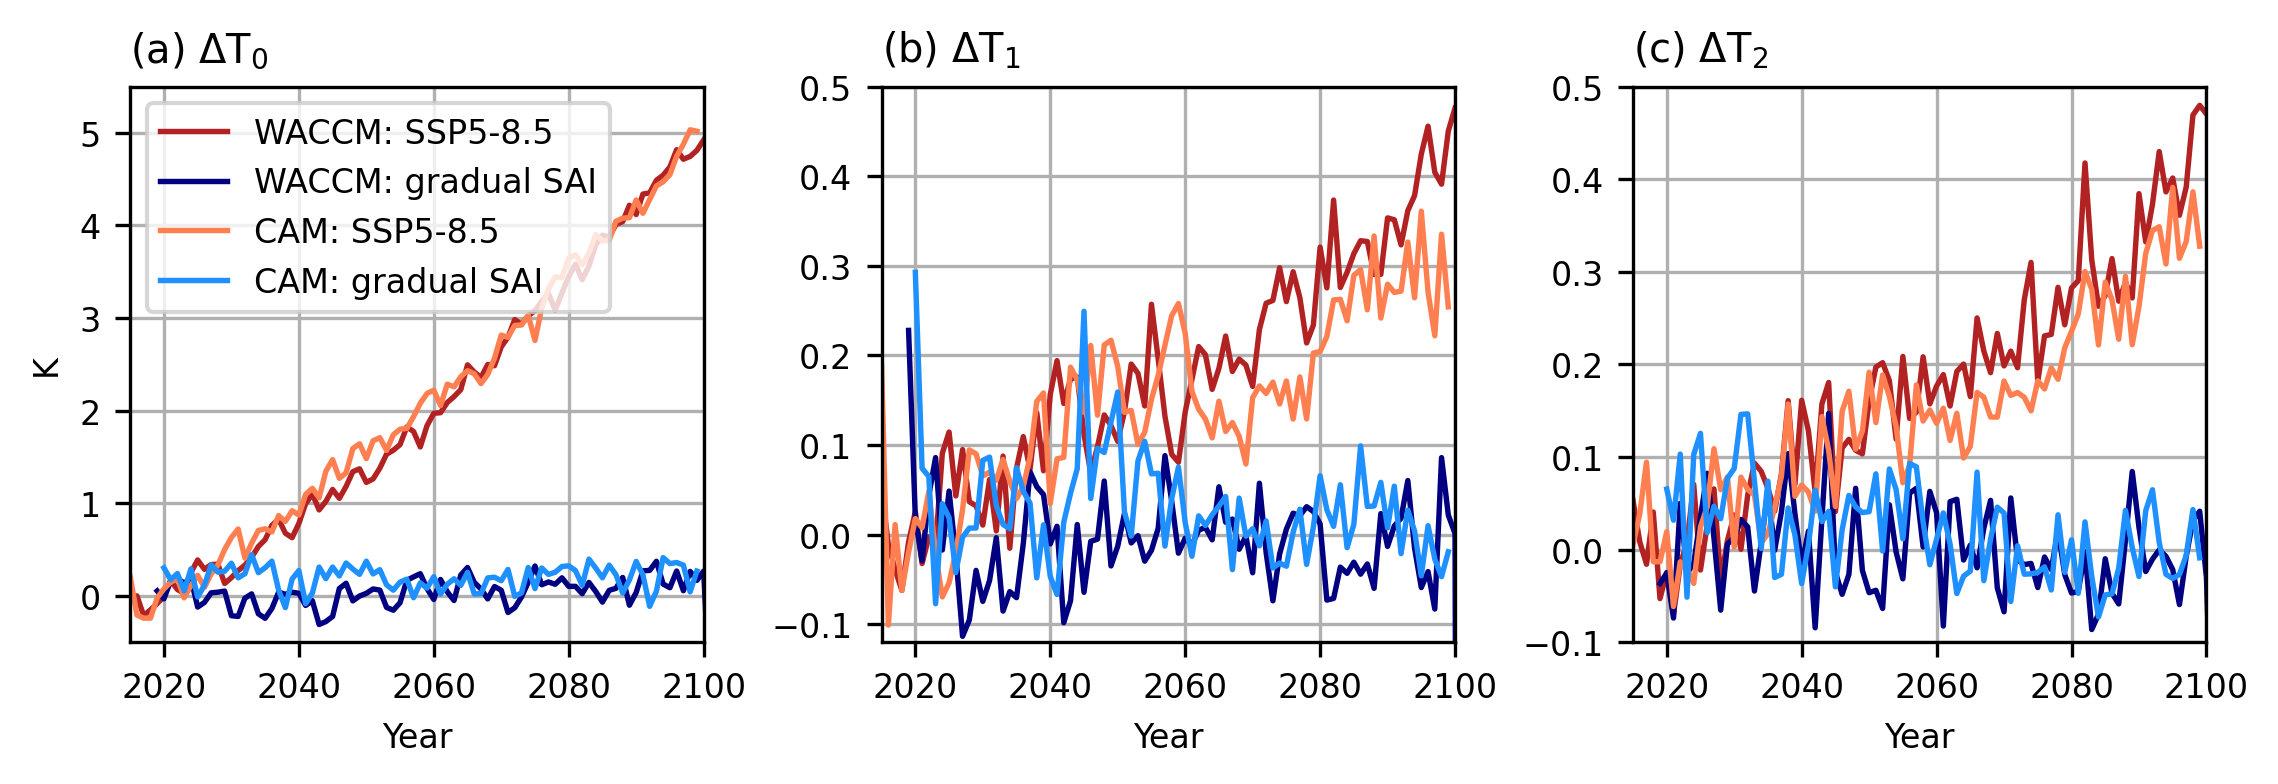

In [71]:
cols = ['firebrick', 'navy', 'coral', 'dodgerblue']
labels = ['WACCM: SSP5-8.5', 'WACCM: gradual SAI', 'CAM: SSP5-8.5', 'CAM: gradual SAI']

fig, axs = plt.subplots(1,3, sharex=True, figsize=imgsize1, layout='constrained')

for i in range(len(deltas)):
    axs[0].plot(time_dict[deltas[i]], deltaT0[deltas[i]], label=labels[i], color=cols[i], linewidth=1.3)

axs[0].set_xlabel('Year')
axs[0].set_ylabel('K')
axs[0].legend()
axs[0].grid()
axs[0].set_ylim(-0.5,5.5)
axs[0].set_xlim(2015,2100)
axs[0].set_title(r'(a) $\Delta$T$_0$', loc='left')


for i in range(len(deltas)):
    axs[1].plot(time_dict[deltas[i]], deltaT1[deltas[i]], color=cols[i], linewidth=1.3)

axs[1].set_xlabel('Year')
axs[1].set_ylabel('')
axs[1].grid()
axs[1].set_ylim(-0.12,0.5)
axs[1].set_title(r'(b) $\Delta$T$_1$', loc='left')


for i in range(len(deltas)):
    axs[2].plot(time_dict[deltas[i]], deltaT2[deltas[i]], color=cols[i], linewidth=1.3)

axs[2].set_xlabel('Year')
axs[2].set_ylabel('')
axs[2].grid()
axs[2].set_ylim(-0.1,0.5)
axs[2].set_title(r'(c) $\Delta$T$_2$', loc='left')

if save == True: plt.savefig(savepath+'Tgrad_v.png'); #plt.savefig(savepath+'Tgrad_2.eps');


# Surface temperature

## Data

In [23]:
### CAM
scenarios['Control'].get_atm_var2('TREFHT')
scenarios['SAI 2020'].get_atm_var2('TREFHT')

scenarios['Control']['TREFHT']['TREFHT'] = scenarios['Control']['TREFHT']['TREFHT'] - 273.15
scenarios['SAI 2020']['TREFHT']['TREFHT'] = scenarios['SAI 2020']['TREFHT']['TREFHT'] - 273.15

In [24]:
### WACCM
trefhtW_ref = CMIP6_get_var('tas')
trefhtW_20 = GLENS2_get_var('TREFHT')
 
trefhtW_ref['tas'] = trefhtW_ref['tas'] - 273.15
trefhtW_20['TREFHT'] = trefhtW_20['TREFHT'] - 273.15


In [25]:
# Surface temperature annual mean
trefht = {
    'C_ref':time_mean(scenarios['Control']['TREFHT'],slice_i)['TREFHT'],
    'C_cnt':time_mean(scenarios['Control']['TREFHT'],slice_f)['TREFHT'],
    'C_20':time_mean(scenarios['SAI 2020']['TREFHT'],slice_f)['TREFHT'],

    'CJJA_ref':time_mean(scenarios['Control']['TREFHT'].sel(time=scenarios['Control']['TREFHT'].time.dt.season=='JJA'),slice_i)['TREFHT'],
    'CJJA_cnt':time_mean(scenarios['Control']['TREFHT'].sel(time=scenarios['Control']['TREFHT'].time.dt.season=='JJA'),slice_f)['TREFHT'],
    'CJJA_20':time_mean(scenarios['SAI 2020']['TREFHT'].sel(time=scenarios['SAI 2020']['TREFHT'].time.dt.season=='JJA'),slice_f)['TREFHT'],

    'CDJF_ref':time_mean(scenarios['Control']['TREFHT'].sel(time=scenarios['Control']['TREFHT'].time.dt.season=='DJF'),slice_i)['TREFHT'],
    'CDJF_cnt':time_mean(scenarios['Control']['TREFHT'].sel(time=scenarios['Control']['TREFHT'].time.dt.season=='DJF'),slice_f)['TREFHT'],
    'CDJF_20':time_mean(scenarios['SAI 2020']['TREFHT'].sel(time=scenarios['SAI 2020']['TREFHT'].time.dt.season=='DJF'),slice_f)['TREFHT'],

    'W_ref':time_mean3(trefhtW_ref,slice_i,'tas'),
    'W_cnt':time_mean3(trefhtW_ref,slice_f,'tas'),
    'W_20':time_mean3(trefhtW_20,slice_f,'TREFHT'),

    'WJJA_ref':time_mean3(trefhtW_ref.sel(time=trefhtW_ref.time.dt.season=='JJA'),slice_i,'tas'),
    'WJJA_cnt':time_mean3(trefhtW_ref.sel(time=trefhtW_ref.time.dt.season=='JJA'),slice_f,'tas'),
    'WJJA_20':time_mean3(trefhtW_20.sel(time=trefhtW_20.time.dt.season=='JJA'),slice_f,'TREFHT'),

    'WDJF_ref':time_mean3(trefhtW_ref.sel(time=trefhtW_ref.time.dt.season=='DJF'),slice_i,'tas'),
    'WDJF_cnt':time_mean3(trefhtW_ref.sel(time=trefhtW_ref.time.dt.season=='DJF'),slice_f,'tas'),
    'WDJF_20':time_mean3(trefhtW_20.sel(time=trefhtW_20.time.dt.season=='DJF'),slice_f,'TREFHT')
}


In [26]:
trefht_d = {}

for i in range(3):
    trefht_d[C_ref[i]] = trefht[C_ref[i]].compute()
    trefht_d[W_ref[i]] = trefht[W_ref[i]].compute()  
    
    trefht_d[C_20ref[i]] = (trefht[C_20[i]] - trefht[C_ref[i]]).compute()
    trefht_d[W_20ref[i]] = (trefht[W_20[i]] - trefht[W_ref[i]]).compute()

    trefht_d[C_cntref[i]] = (trefht[C_cnt[i]] - trefht[C_ref[i]]).compute()
    trefht_d[W_cntref[i]] = (trefht[W_cnt[i]] - trefht[W_ref[i]]).compute()
    
    trefht_d[C_20cnt[i]] = (trefht[C_20[i]] - trefht[C_cnt[i]]).compute()
    trefht_d[W_20cnt[i]] = (trefht[W_20[i]] - trefht[W_cnt[i]]).compute()
    
    trefht_d[CW2[i]] = (trefht_d[C_20ref[i]] - trefht_d[W_20ref[i]]).compute()

trefht_d['CWref'] = trefht['C_ref'] - trefht['W_ref']
trefht_d['CWcnt'] = trefht['C_cnt'] - trefht['W_cnt']
trefht_d['CW20'] = trefht['C_20'] - trefht['W_20']



In [27]:
trefht_zma = {}

for i in range(len(C_20ref)):
    trefht_zma[C_zma[i]] = trefht_d[C_20ref[i]].mean(dim='lon').compute()
    trefht_zma[W_zma[i]] = trefht_d[W_20ref[i]].mean(dim='lon').compute()


## Plots

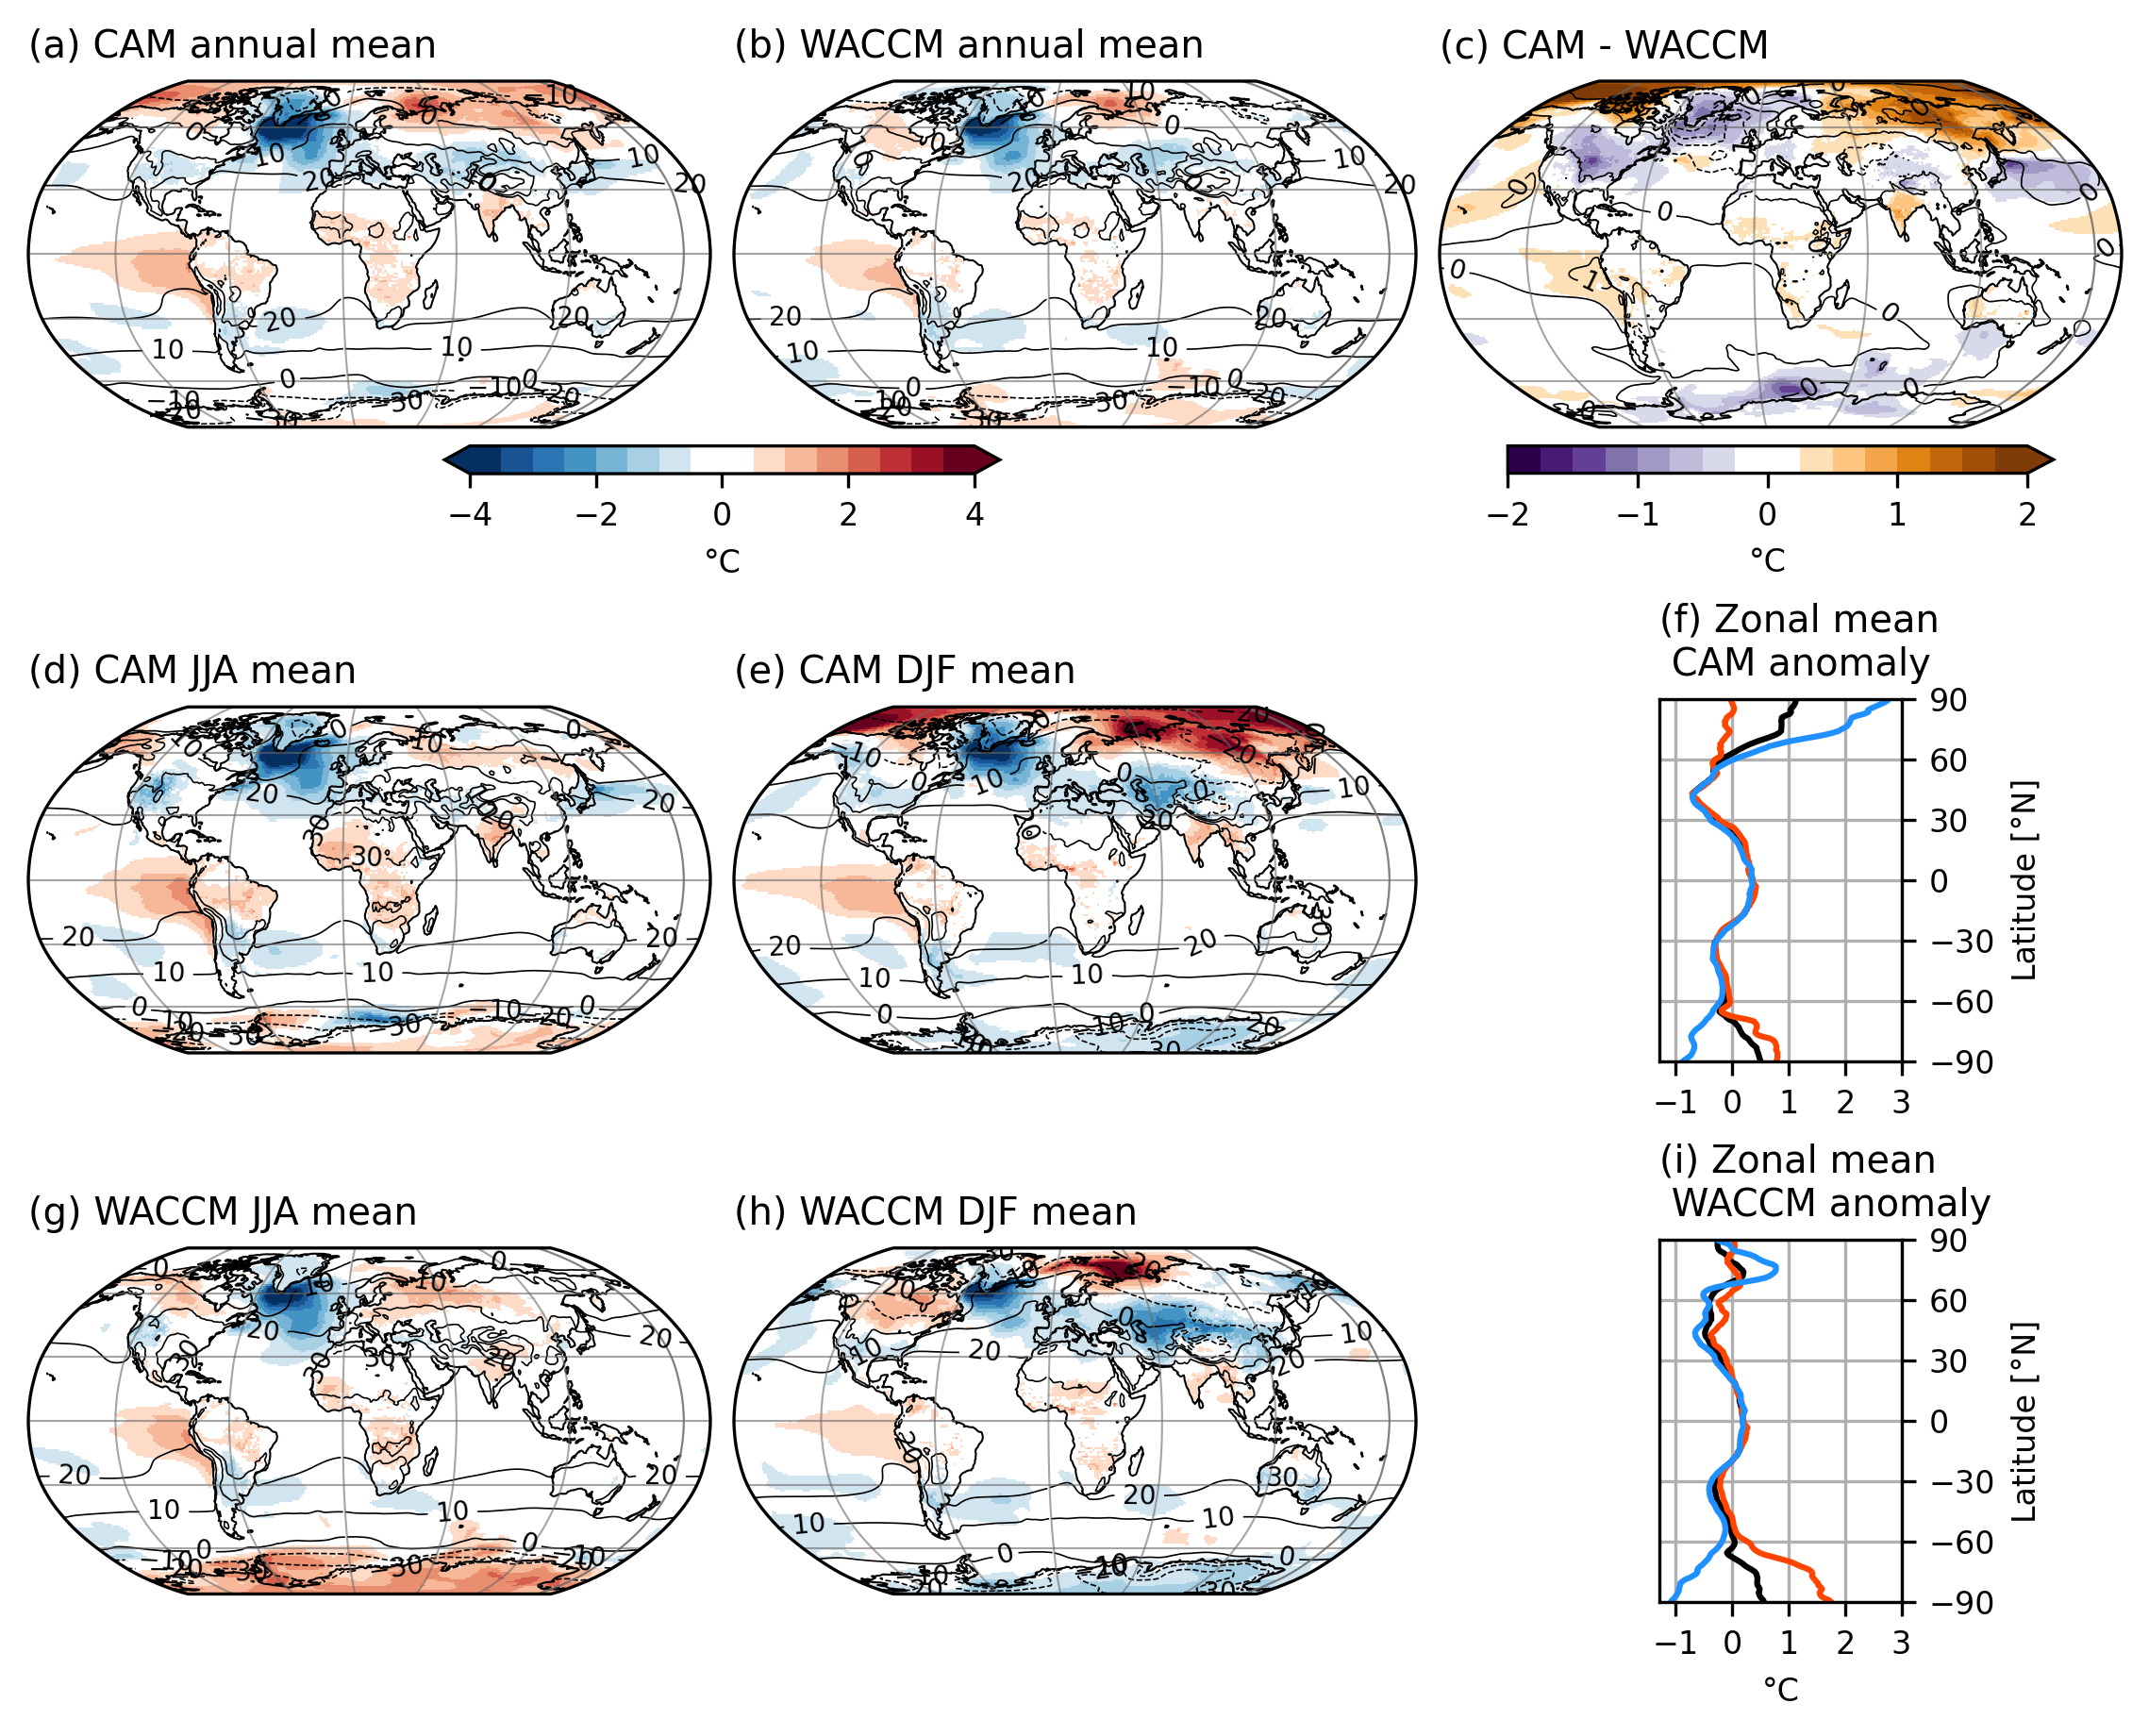

In [28]:
scens = np.stack((C_20ref, W_20ref, CW2, C_ref, W_ref)).T 
scens[1:,:2] = scens[1:,:2].T
scens[1:,3:] = scens[1:,3:].T
sn_scen = np.asarray([['C', 'CJJA', 'CDJF'],['W', 'WJJA', 'WDJF']])
labels = np.asarray([['(a) CAM annual mean', '(b) WACCM annual mean', '(c) CAM - WACCM'], ['(d) CAM JJA mean', '(e) CAM DJF mean', '(f) Zonal mean \n CAM anomaly'],['(g) WACCM JJA mean', '(h) WACCM DJF mean', '(i) Zonal mean \n WACCM anomaly']])
colorlist = ['k', 'orangered', 'dodgerblue']

fig, ax = plt.subplots(3,3, figsize=imgsize5, layout='constrained', subplot_kw={'projection':ccrs.Robinson(central_longitude=14)})

yoink = mpl.colormaps['RdBu_r'].resampled(16)
newcolors = yoink(np.linspace(0,1,16))
white = np.array([1, 1, 1, 1])
newcolors[7:9,:] = white
newcmap = colors.ListedColormap(newcolors)

yoink = mpl.colormaps['PuOr_r'].resampled(16)
newcolors = yoink(np.linspace(0,1,16))
white = np.array([1, 1, 1, 1])
newcolors[7:9,:] = white
newcmap2 = colors.ListedColormap(newcolors)

for i in range(2):
    ax[0,i].coastlines(resolution='110m', linewidth=0.5)

    im = trefht_d[scens[0,i]].plot(ax=ax[0,i], transform=ccrs.PlateCarree(), cmap=newcmap, vmin=-4, vmax=4, add_colorbar=False)
    gl = ax[0,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')

    plot = trefht_d[scens[0,i+3]].plot.contour(ax=ax[0,i], transform=ccrs.PlateCarree(), colors='k', linewidths=0.4, vmin=-30, vmax=30, levels=7, kwargs=dict(inline=True))
    ax[0,i].clabel(plot, fontsize='small', inline_spacing=1)

    ax[0,i].set_title(labels[0,i], loc='left')


ax[0,2].coastlines(resolution='110m', linewidth=0.5)

im3 = trefht_d[scens[0,2]].plot(ax=ax[0,2], transform=ccrs.PlateCarree(), cmap=newcmap2, vmin=-2, vmax=2, add_colorbar=False)
gl3 = ax[0,2].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')

plot3 = trefht_d[scens[0,1]].plot.contour(ax=ax[0,2], transform=ccrs.PlateCarree(), colors='k', linewidths=0.4, vmin=-4, vmax=4, levels=9, kwargs=dict(inline=True))
ax[0,2].clabel(plot3, fontsize='small', inline_spacing=1)

ax[0,2].set_title(labels[0,2], loc='left')

plt.colorbar(im, ax=ax[0,:2], shrink=0.4, location='bottom', label='°C', extend='both')
plt.colorbar(im3, ax=ax[0,-1], shrink=0.8, location='bottom', label='°C', extend='max')


ax[1,2].remove()
ax[1,2] = fig.add_subplot(3, 3, 6, projection=None, box_aspect=1.5)
ax[2,2].remove()
ax[2,2] = fig.add_subplot(3, 3, 9, projection=None, sharex=ax[1,2], box_aspect=1.5)

for j in (1,2):
    for i in (0,1): 
        ax[j,i].coastlines(resolution='110m', linewidth=0.5)
    
        im = trefht_d[scens[j,i]].plot(ax=ax[j,i], transform=ccrs.PlateCarree(), cmap=newcmap, vmin=-4, vmax=4, add_colorbar=False)
        gl = ax[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')
    
        plot = trefht_d[scens[j,i+3]].plot.contour(ax=ax[j,i], transform=ccrs.PlateCarree(), colors='k', linewidths=0.4, vmin=-30, vmax=30, levels=7, kwargs=dict(inline=True))
        ax[j,i].clabel(plot, fontsize='small', inline_spacing=1)
    
        ax[j,i].set_title(labels[j,i], loc='left')

    for i in range(3):
        
        im3 = trefht_zma[sn_scen[j-1,i]].plot(ax=ax[j,2], y='lat', color=colorlist[i])
    
    ax[j,2].set_ylim(-90,90)
    ax[j,2].set_xlabel('')
    ax[j,2].set_ylabel('Latitude [°N]')
    ax[j,2].set_xticks([-1,0,1,2,3])
    ax[j,2].set_yticks([-90,-60,-30,0,30,60,90])
    ax[j,2].yaxis.set_ticks_position("right")
    ax[j,2].yaxis.set_label_position("right")
    ax[j,2].grid()
    ax[j,2].set_title(label=labels[j,2], loc='left')

ax[2,2].set_xlabel('°C')

# plt.colorbar(im, ax=ax[:,:2], shrink=0.4, location='bottom', label='°C', extend='both', pad=0.)


if save == True: plt.savefig(savepath+'TREFHT_20ref.png', bbox_inches = 'tight'); #plt.savefig(savepath+'TREFHT_20ref.eps', bbox_inches = 'tight');


# Precipitation

## Data

In [29]:
### CAM
scenarios['Control'].get_atm_var2('PRECT')
scenarios['SAI 2020'].get_atm_var2('PRECL')
scenarios['SAI 2020'].get_atm_var2('PRECC')

scenarios['Control']['PRECT']['PRECT'] = scenarios['Control']['PRECT']['PRECT']*1000
scenarios['SAI 2020']['PRECL']['PRECL'] = scenarios['SAI 2020']['PRECL']['PRECL']*1000
scenarios['SAI 2020']['PRECC']['PRECC'] = scenarios['SAI 2020']['PRECC']['PRECC']*1000


In [30]:
### WACCM
prectW_ref = CMIP6_get_var('pr')
prectW_20 = GLENS2_get_var('PRECT')

prectW_20['PRECT'] = prectW_20['PRECT']*1000


In [31]:
prect = {
    'C_ref':time_mean(scenarios['Control']['PRECT'],slice_i)['PRECT']*86400,
    'C_cnt':time_mean(scenarios['Control']['PRECT'],slice_f)['PRECT']*86400,
    'C_20':time_mean(scenarios['SAI 2020']['PRECL'],slice_f)['PRECL']*86400+time_mean(scenarios['SAI 2020']['PRECC'],slice_f)['PRECC']*86400,

    'CJJA_ref':time_mean(scenarios['Control']['PRECT'].sel(time=scenarios['Control']['PRECT'].time.dt.season=='JJA'),slice_i)['PRECT']*86400,
    'CJJA_cnt':time_mean(scenarios['Control']['PRECT'].sel(time=scenarios['Control']['TREFHT'].time.dt.season=='JJA'),slice_f)['PRECT']*86400,
    'CJJA_20':time_mean(scenarios['SAI 2020']['PRECL'].sel(time=scenarios['SAI 2020']['PRECL'].time.dt.season=='JJA'),slice_f)['PRECL']*86400
                + time_mean(scenarios['SAI 2020']['PRECC'].sel(time=scenarios['SAI 2020']['PRECC'].time.dt.season=='JJA'),slice_f)['PRECC']*86400,

    'CDJF_ref':time_mean(scenarios['Control']['PRECT'].sel(time=scenarios['Control']['PRECT'].time.dt.season=='DJF'),slice_i)['PRECT']*86400,
    'CDJF_cnt':time_mean(scenarios['Control']['PRECT'].sel(time=scenarios['Control']['TREFHT'].time.dt.season=='DJF'),slice_f)['PRECT']*86400,
    'CDJF_20':time_mean(scenarios['SAI 2020']['PRECL'].sel(time=scenarios['SAI 2020']['PRECL'].time.dt.season=='DJF'),slice_f)['PRECL']*86400
                + time_mean(scenarios['SAI 2020']['PRECC'].sel(time=scenarios['SAI 2020']['PRECC'].time.dt.season=='DJF'),slice_f)['PRECC']*86400,

    'W_ref':time_mean3(prectW_ref,slice_i,'pr')*86400,
    'W_cnt':time_mean3(prectW_ref,slice_f,'pr')*86400,
    'W_20':time_mean3(prectW_20,slice_f,'PRECT')*86400,

    'WJJA_ref':time_mean3(prectW_ref.sel(time=prectW_ref.time.dt.season=='JJA'),slice_i,'pr')*86400,
    'WJJA_cnt':time_mean3(prectW_ref.sel(time=trefhtW_ref.time.dt.season=='JJA'),slice_f,'pr')*86400,
    'WJJA_20':time_mean3(prectW_20.sel(time=prectW_20.time.dt.season=='JJA'),slice_f,'PRECT')*86400,

    'WDJF_ref':time_mean3(prectW_ref.sel(time=prectW_ref.time.dt.season=='DJF'),slice_i,'pr')*86400,
    'WDJF_cnt':time_mean3(prectW_ref.sel(time=trefhtW_ref.time.dt.season=='DJF'),slice_f,'pr')*86400,
    'WDJF_20':time_mean3(prectW_20.sel(time=prectW_20.time.dt.season=='DJF'),slice_f,'PRECT')*86400
}
    


In [32]:
# psl = {
#     'C_ref':time_mean(scenarios['Control']['PSL'],slice('2015','2035'))['PSL'].compute(),
#     'CJJA_ref':time_mean(scenarios['Control']['PSL'].sel(time=scenarios['Control']['PSL'].time.dt.season=='JJA'),slice_i)['PSL'].compute(),
#     'CDJF_ref':time_mean(scenarios['Control']['PSL'].sel(time=scenarios['Control']['PSL'].time.dt.season=='DJF'),slice_i)['PSL'].compute(),

#     'W_ref':time_mean3(psW_ref,slice_i,'psl').compute(),
#     'WJJA_ref':time_mean3(psW_ref.sel(time=psW_ref.time.dt.season=='JJA'),slice_i,'psl').compute(),
#     'WDJF_ref':time_mean3(psW_ref.sel(time=psW_ref.time.dt.season=='DJF'),slice_i,'psl').compute()
# }

In [33]:
prect_d = {}

for i in range(3):
    prect_d[C_ref[i]] = prect[C_ref[i]].compute()
    prect_d[W_ref[i]] = prect[W_ref[i]].compute()   
    
    prect_d[C_20ref[i]] = ((prect[C_20[i]] - prect[C_ref[i]])/prect[C_ref[i]]*100).compute()
    prect_d[W_20ref[i]] = ((prect[W_20[i]] - prect[W_ref[i]])/prect[W_ref[i]]*100).compute()

    prect_d[C_cntref[i]] = ((prect[C_cnt[i]] - prect[C_ref[i]])/prect[C_ref[i]]*100).compute()
    prect_d[W_cntref[i]] = ((prect[W_cnt[i]] - prect[W_ref[i]])/prect[W_ref[i]]*100).compute()

    prect_d[C_20cnt[i]] = ((prect[C_20[i]] - prect[C_cnt[i]])/prect[C_ref[i]]*100).compute()
    prect_d[W_20cnt[i]] = ((prect[W_20[i]] - prect[W_cnt[i]])/prect[W_ref[i]]*100).compute()

    prect_d[CW2[i]] = (prect_d[C_20ref[i]] - prect_d[W_20ref[i]]).compute()
    
prect_d['CWref'] = prect['C_ref'] - prect['W_ref']
prect_d['CWcnt'] = prect['C_cnt'] - prect['W_cnt']
prect_d['CW20'] = prect['C_20'] - prect['W_20']



In [34]:
prect_zma = {}

for i in range(len(C_20ref)):
    prect_zma[C_zma[i]] = prect_d[C_20ref[i]].mean(dim='lon').compute()
    prect_zma[W_zma[i]] = prect_d[W_20ref[i]].mean(dim='lon').compute()

## Plots

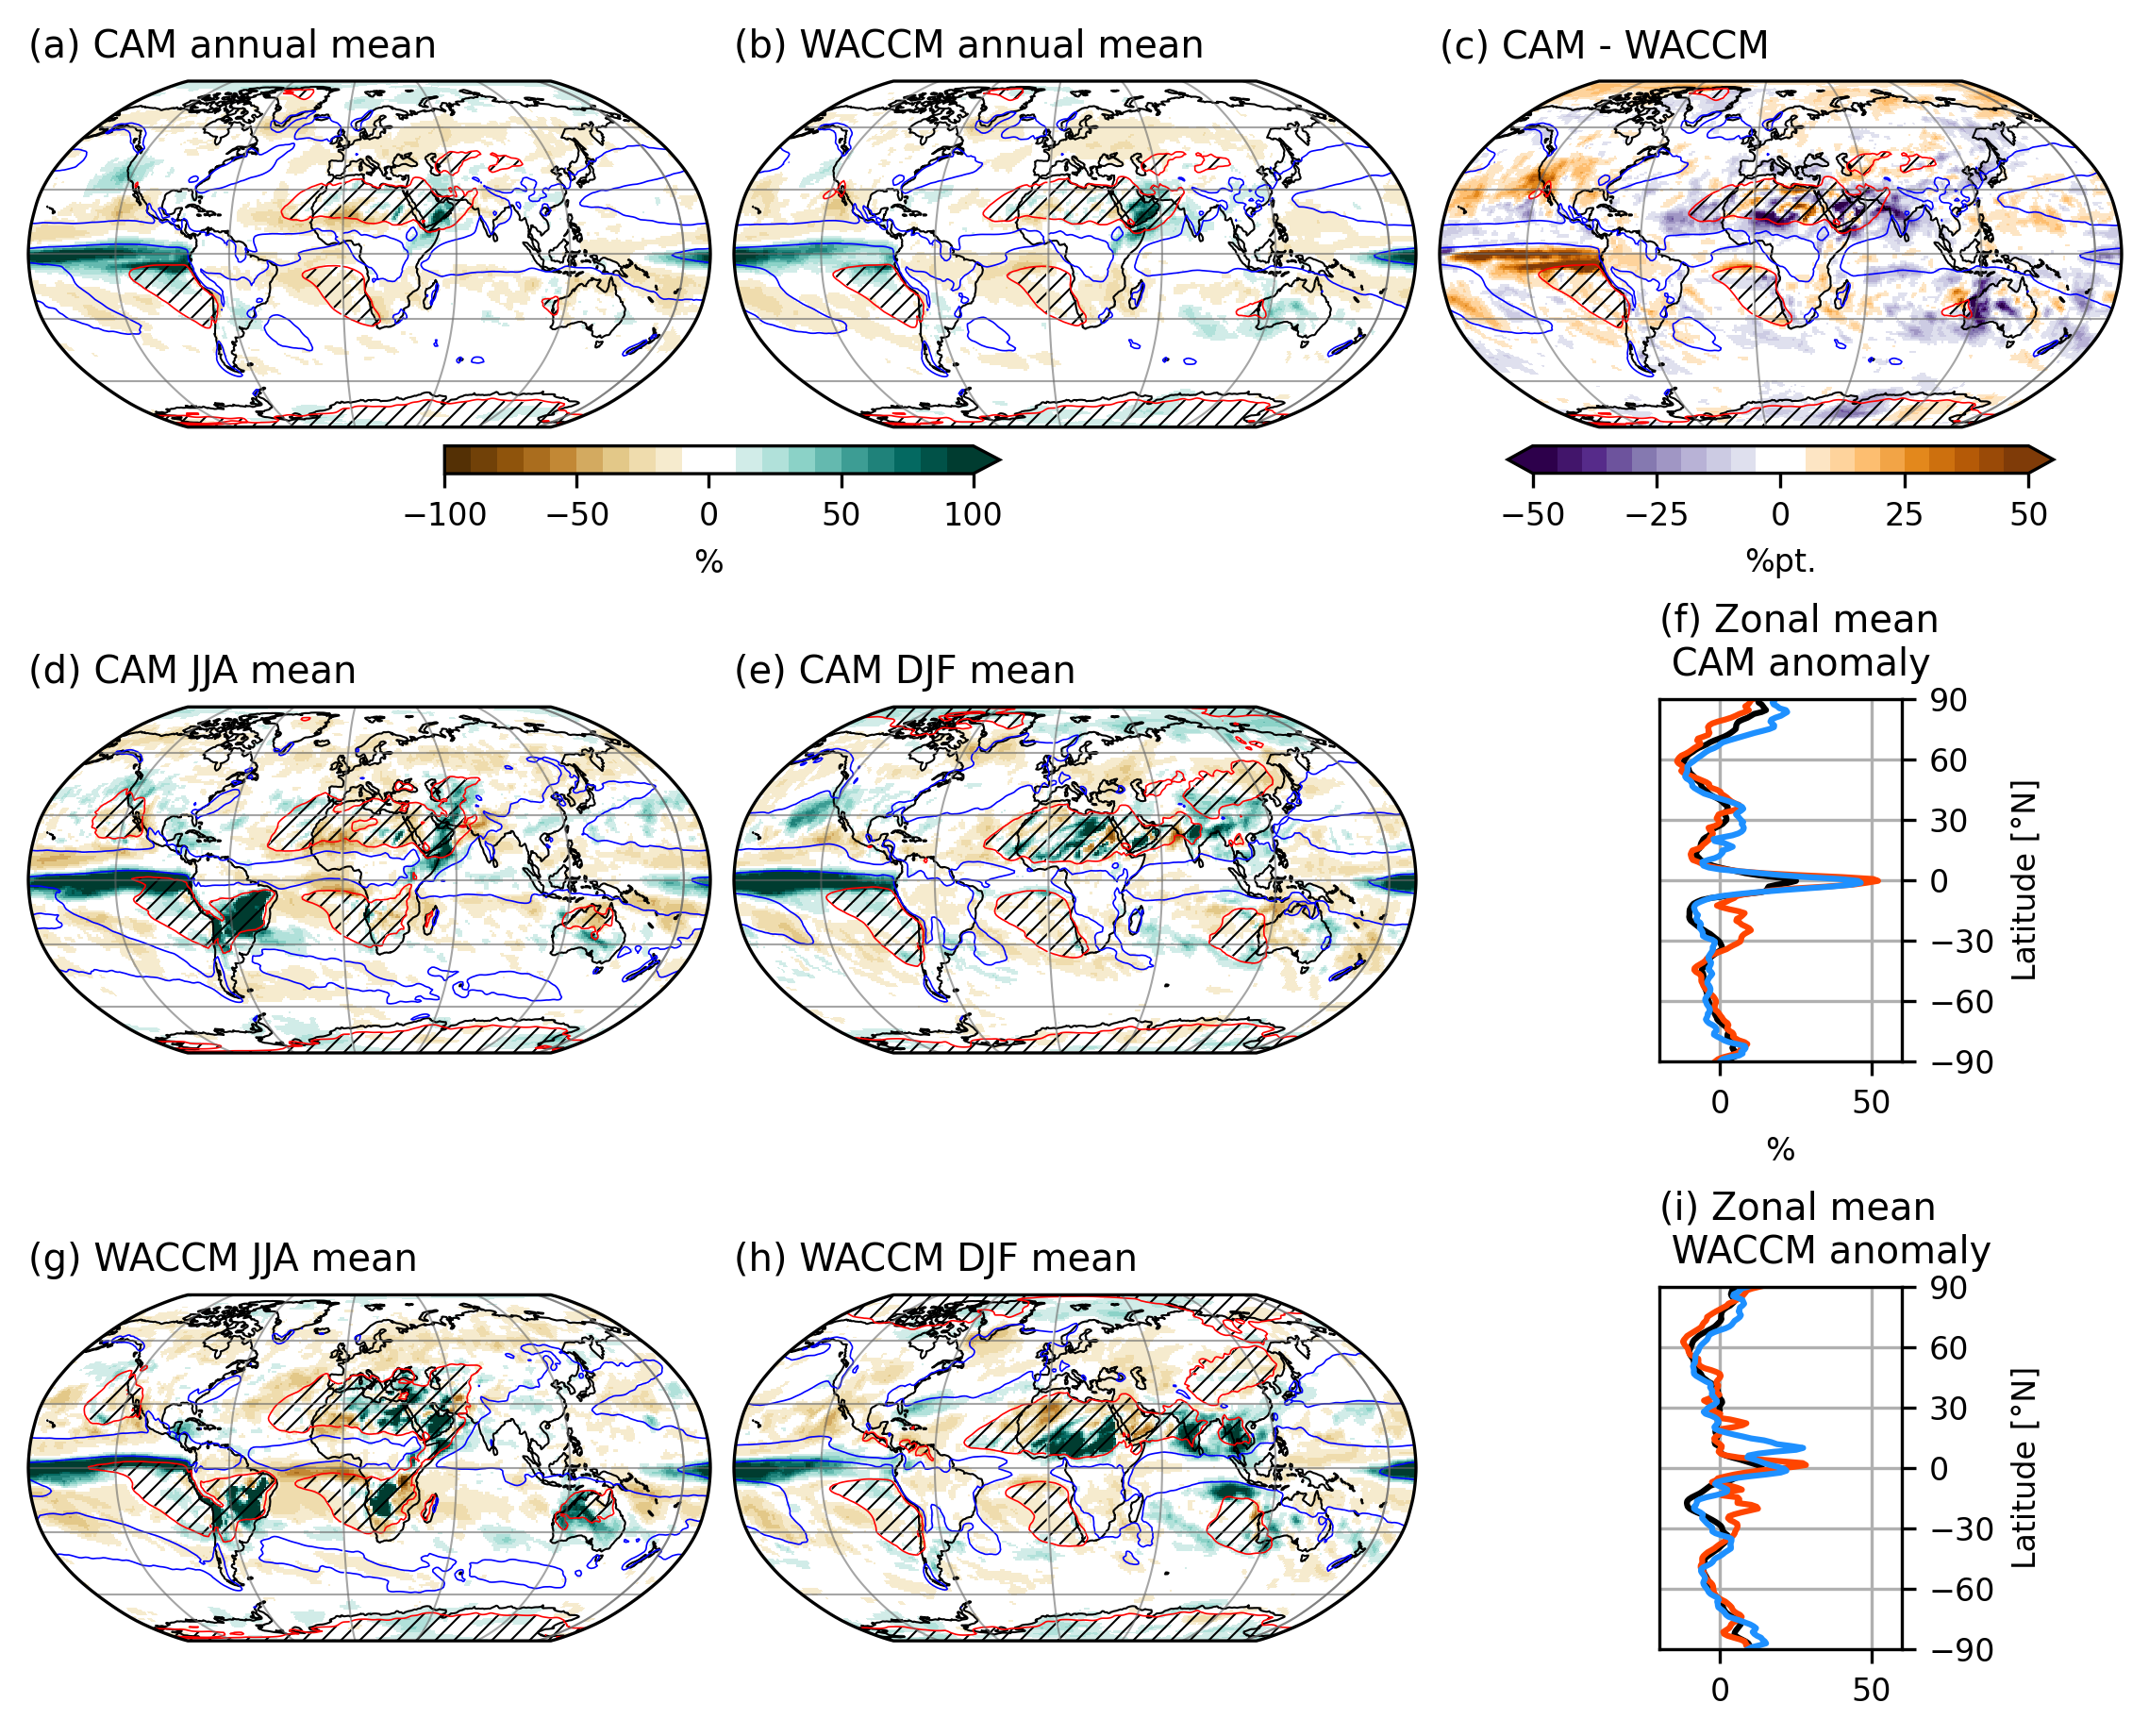

In [35]:
scens = np.stack((C_20ref, W_20ref, CW2, C_ref, W_ref)).T 
scens[1:,:2] = scens[1:,:2].T
scens[1:,3:] = scens[1:,3:].T
sn_scen = np.asarray([['C', 'CJJA', 'CDJF'],['W', 'WJJA', 'WDJF']])
labels = np.asarray([['(a) CAM annual mean', '(b) WACCM annual mean', '(c) CAM - WACCM'], 
                     ['(d) CAM JJA mean', '(e) CAM DJF mean', '(f) Zonal mean \n CAM anomaly'],
                     ['(g) WACCM JJA mean', '(h) WACCM DJF mean', '(i) Zonal mean \n WACCM anomaly']])
colorlist = ['k', 'orangered', 'dodgerblue']

fig, ax = plt.subplots(3,3, figsize=imgsize5, layout='constrained', subplot_kw={'projection':ccrs.Robinson(central_longitude=14)})

yoink = mpl.colormaps['BrBG'].resampled(20)
newcolors = yoink(np.linspace(0,1,20))
white = np.array([1, 1, 1, 1])
newcolors[9:11,:] = white
newcmap = colors.ListedColormap(newcolors)

yoink = mpl.colormaps['PuOr_r'].resampled(20)
newcolors = yoink(np.linspace(0,1,20))
white = np.array([1, 1, 1, 1])
newcolors[9:11,:] = white
newcmap2 = colors.ListedColormap(newcolors)

for i in range(2):
    ax[0,i].coastlines(resolution='110m', linewidth=0.5)

    im = prect_d[scens[0][i]].plot(ax=ax[0,i], transform=ccrs.PlateCarree(), cmap=newcmap, vmin=-100, vmax=100, add_colorbar=False)
    gl = ax[0,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')

    plota = prect_d[scens[0][i+3]].plot.contour(ax=ax[0,i], transform=ccrs.PlateCarree(), colors=['red','b'], linewidths=0.4, levels=[0.5,4], kwargs=dict(inline=True))

    thresh = xr.where(prect_d[scens[0][i+3]] < 0.5, True, np.nan, keep_attrs=True)
    plotb = xr.plot.contourf(darray=thresh, ax=ax[0,i], transform=ccrs.PlateCarree(), hatches=['/////'], colors=None, alpha=0., add_colorbar=False)
    
    ax[0,i].set_title(labels[0,i], loc='left')


ax[0,2].coastlines(resolution='110m', linewidth=0.5)

im3 = prect_d[scens[0,2]].plot(ax=ax[0,2], transform=ccrs.PlateCarree(), cmap=newcmap2, vmin=-50, vmax=50, add_colorbar=False)
gl3 = ax[0,2].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')

plota = prect_d[scens[0,-1]].plot.contour(ax=ax[0,2], transform=ccrs.PlateCarree(), colors=['red','b'], linewidths=0.4, levels=[0.5,4], kwargs=dict(inline=True))

thresh = xr.where(prect_d[scens[0,-1]] < 0.5, True, np.nan, keep_attrs=True)
plotb = xr.plot.contourf(darray=thresh, ax=ax[0,2], transform=ccrs.PlateCarree(), hatches=['/////'], colors=None, alpha=0., add_colorbar=False)

ax[0,2].set_title(labels[0,2], loc='left')

plt.colorbar(im, ax=ax[0,:2], shrink=0.4, location='bottom', label='%', extend='max', ticks=[-100,-50,0,50,100])
plt.colorbar(im3, ax=ax[0,-1], shrink=0.8, location='bottom', label='%pt.', extend='both', ticks=[-50,-25,0,25,50])


ax[1,2].remove()
ax[1,2] = fig.add_subplot(3, 3, 6, projection=None, box_aspect=1.5)
ax[2,2].remove()
ax[2,2] = fig.add_subplot(3, 3, 9, projection=None, sharex=ax[1,2], box_aspect=1.5)

for j in (1,2):
    for i in (0,1):
        ax[j,i].coastlines(resolution='110m', linewidth=0.5)
    
        im = prect_d[scens[j,i]].plot(ax=ax[j,i], transform=ccrs.PlateCarree(), cmap=newcmap, vmin=-100, vmax=100, add_colorbar=False)
        gl = ax[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')
    
        plota = prect_d[scens[j,i+3]].plot.contour(ax=ax[j,i], transform=ccrs.PlateCarree(), colors=['red','b'], linewidths=0.4, levels=[0.5,4], kwargs=dict(inline=True))

        thresh = xr.where(prect_d[scens[j,i+3]] < 0.5, True, np.nan, keep_attrs=True)
        plot = xr.plot.contourf(darray=thresh, ax=ax[j,i], transform=ccrs.PlateCarree(), hatches=['/////'], colors=None, alpha=0., add_colorbar=False)
    
        ax[j,i].set_title(labels[j,i], loc='left')

    for i in range(3):
        
        im3 = prect_zma[sn_scen[j-1,i]].plot(ax=ax[j,2], y='lat', color=colorlist[i])
    
    ax[j,2].set_xlim(-20,60)
    ax[j,2].set_ylim(-90,90)
    ax[j,2].set_xlabel('')
    ax[j,2].set_ylabel('Latitude [°N]')
    ax[j,2].set_yticks([-90,-60,-30,0,30,60,90])
    ax[j,2].yaxis.set_ticks_position("right")
    ax[j,2].yaxis.set_label_position("right")
    ax[j,2].grid()
    ax[j,2].set_title(label=labels[j,2], loc='left')

ax[1,2].set_xlabel('%')


if save == True: plt.savefig(savepath+'PRECT_20ref.png', bbox_inches = 'tight')#plt.savefig(savepath+'PRECT_20ref.eps', bbox_inches = 'tight');


# Temperature + precipitation

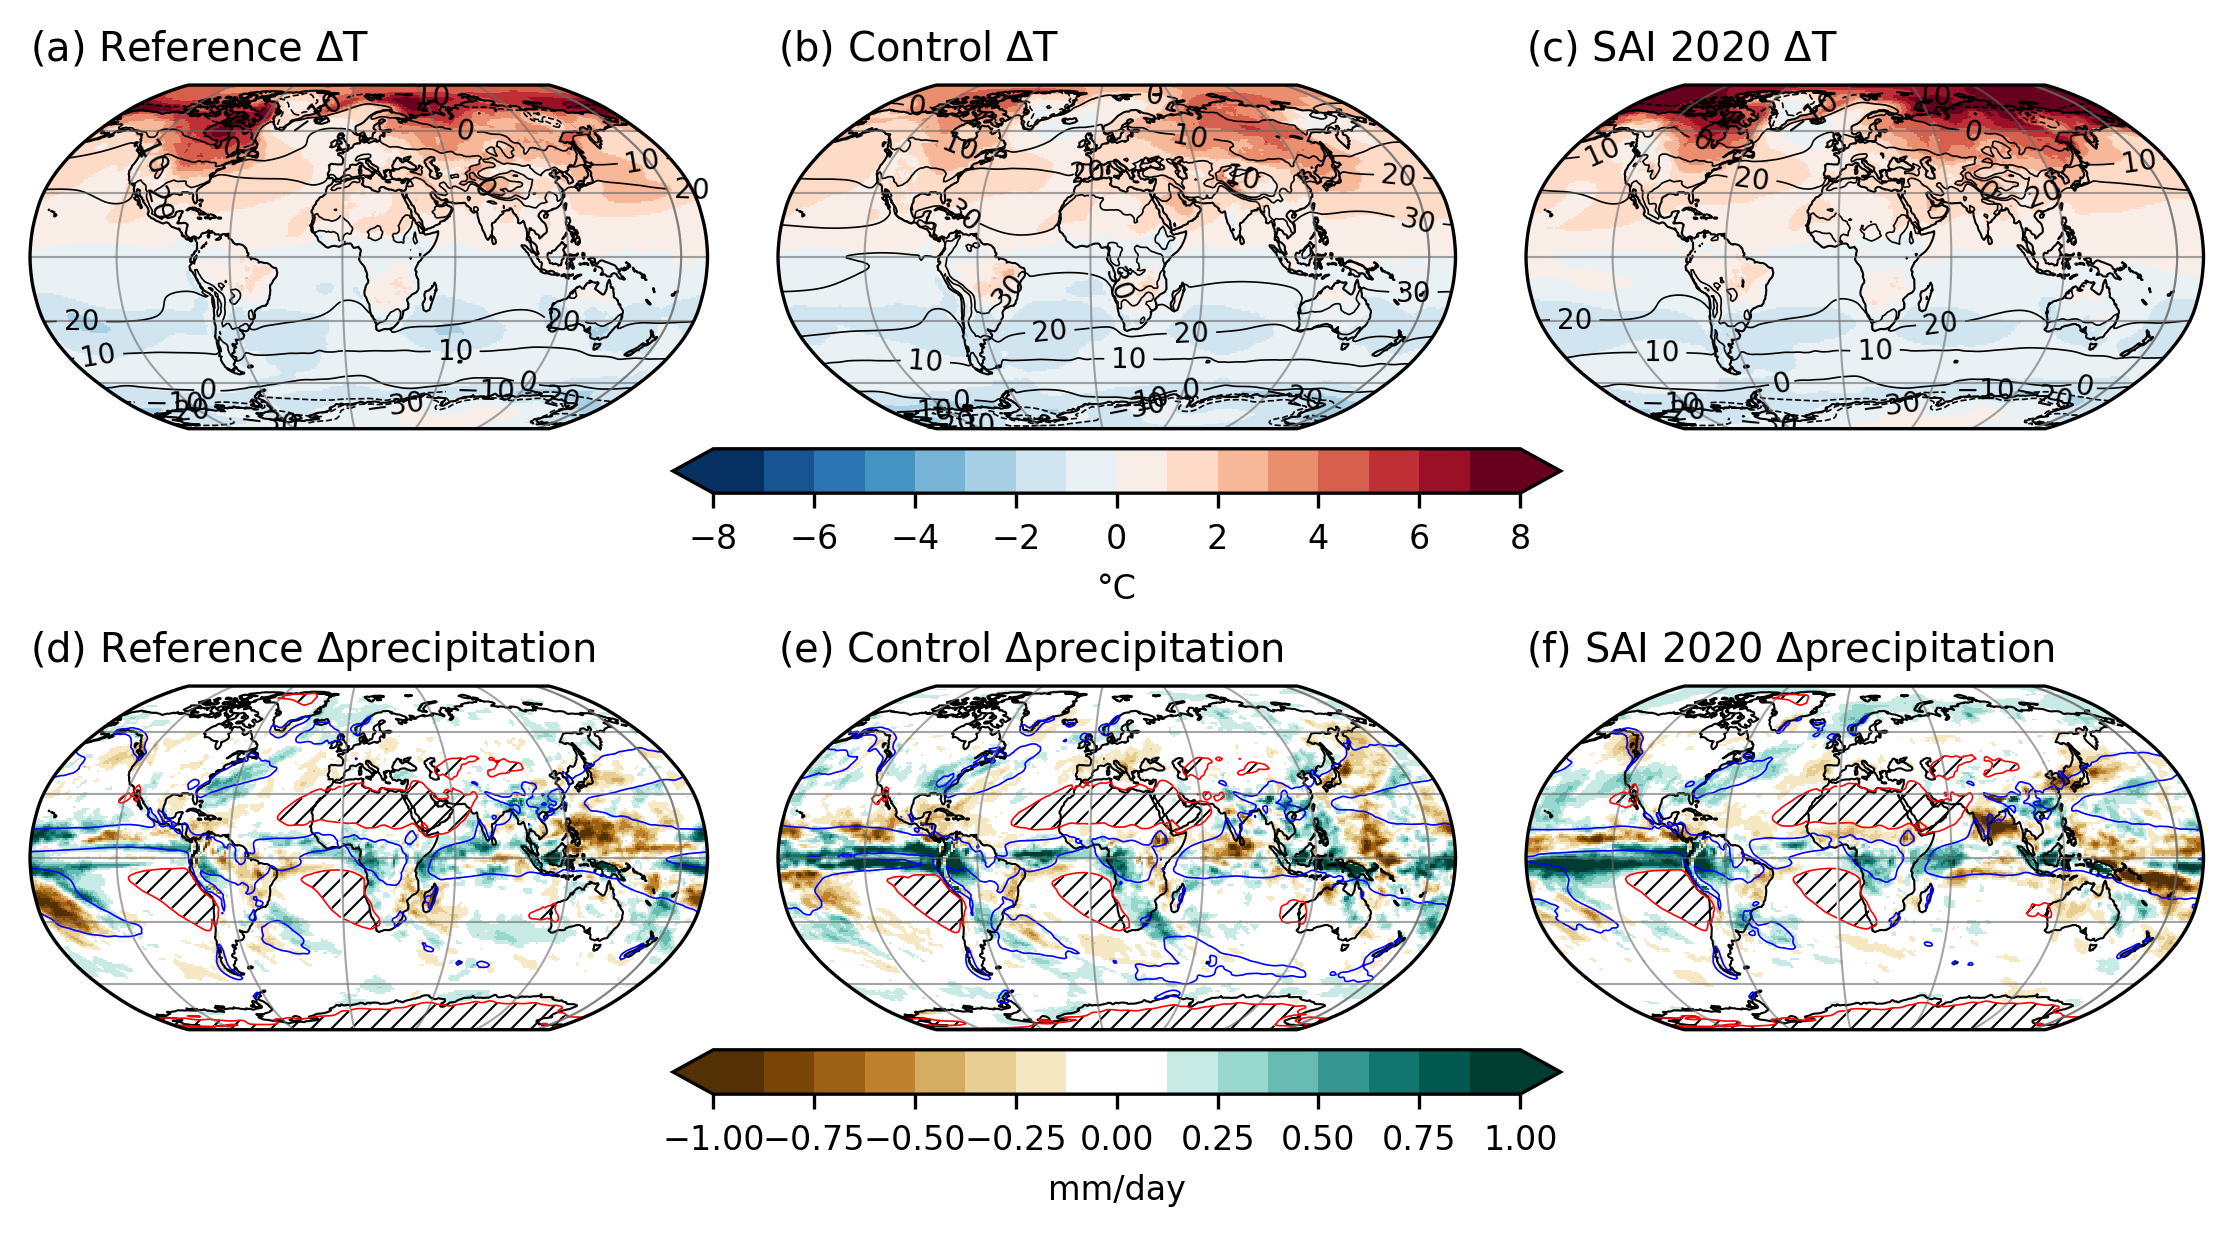

In [ ]:
scens = CW
scens_t = ['W_ref', 'W_cnt', 'W_20']
labels = np.asarray([['(a) Reference $\Delta$T', '(b) Control $\Delta$T', '(c) SAI 2020 $\Delta$T'], 
                     ['(d) Reference $\Delta$precipitation', '(e) Control $\Delta$precipitation', '(f) SAI 2020 $\Delta$precipitation']])

fig, ax = plt.subplots(2,3, figsize=imgsize3, layout='constrained', subplot_kw={'projection':ccrs.Robinson(central_longitude=14)})

yoink = mpl.colormaps['RdBu_r'].resampled(16)
newcolors = yoink(np.linspace(0,1,16))
# white = np.array([1, 1, 1, 1])
# newcolors[7:9,:] = white
newcmap = colors.ListedColormap(newcolors)

yoink = mpl.colormaps['BrBG'].resampled(16)
newcolors = yoink(np.linspace(0,1,16))
white = np.array([1, 1, 1, 1])
newcolors[7:9,:] = white
newcmap2 = colors.ListedColormap(newcolors)
# newcmap2 = newcmap2.resampled(8)


for j in range(3):
    for i in range(2):  
        if i == 0:
            ax[i,j].coastlines(resolution='110m', linewidth=0.5)
            
            ima = trefht_d[scens[j]].plot(ax=ax[i,j], transform=ccrs.PlateCarree(), cmap=newcmap, vmin=-8, vmax=8, add_colorbar=False)
            gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')
        
            plot = trefht[scens_t[j]].plot.contour(ax=ax[i,j], transform=ccrs.PlateCarree(), colors='k', linewidths=0.4, vmin=-30, vmax=30, levels=7, kwargs=dict(inline=True))
            ax[i,j].clabel(plot, fontsize='small', inline_spacing=1)
        
            ax[i,j].set_title(labels[i,j], loc='left')
        if i == 1:
            ax[i,j].coastlines(resolution='110m', linewidth=0.5)

            imb = prect_d[scens[j]].plot(ax=ax[i,j], transform=ccrs.PlateCarree(), cmap=newcmap2, vmin=-1, vmax=1, add_colorbar=False)
            gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')
        
            plota = prect[scens_t[j]].plot.contour(ax=ax[i,j], transform=ccrs.PlateCarree(), colors=['red','b'], linewidths=0.4, levels=[0.5,4], kwargs=dict(inline=True))
        
            thresh = xr.where(prect[scens_t[j]] < 0.5, True, np.nan, keep_attrs=True)
            plotb = xr.plot.contourf(darray=thresh, ax=ax[i,j], transform=ccrs.PlateCarree(), hatches=['/////'], colors=None, alpha=0., add_colorbar=False)
            
            ax[i,j].set_title(labels[i,j], loc='left')

plt.colorbar(ima, ax=ax[0,:], shrink=0.4, location='bottom', label='°C', extend='both')#, ticks=[-30,-20,-10,0,10,20,30])
plt.colorbar(imb, ax=ax[1,:], shrink=0.4, location='bottom', label='mm/day', extend='both')#, ticks=[-8,-4,0,4,8])


if save == True: plt.savefig(savepath+'CAM_WACCM.png', bbox_inches = 'tight')#plt.savefig(savepath+'CAM_WACCM.eps', bbox_inches = 'tight');


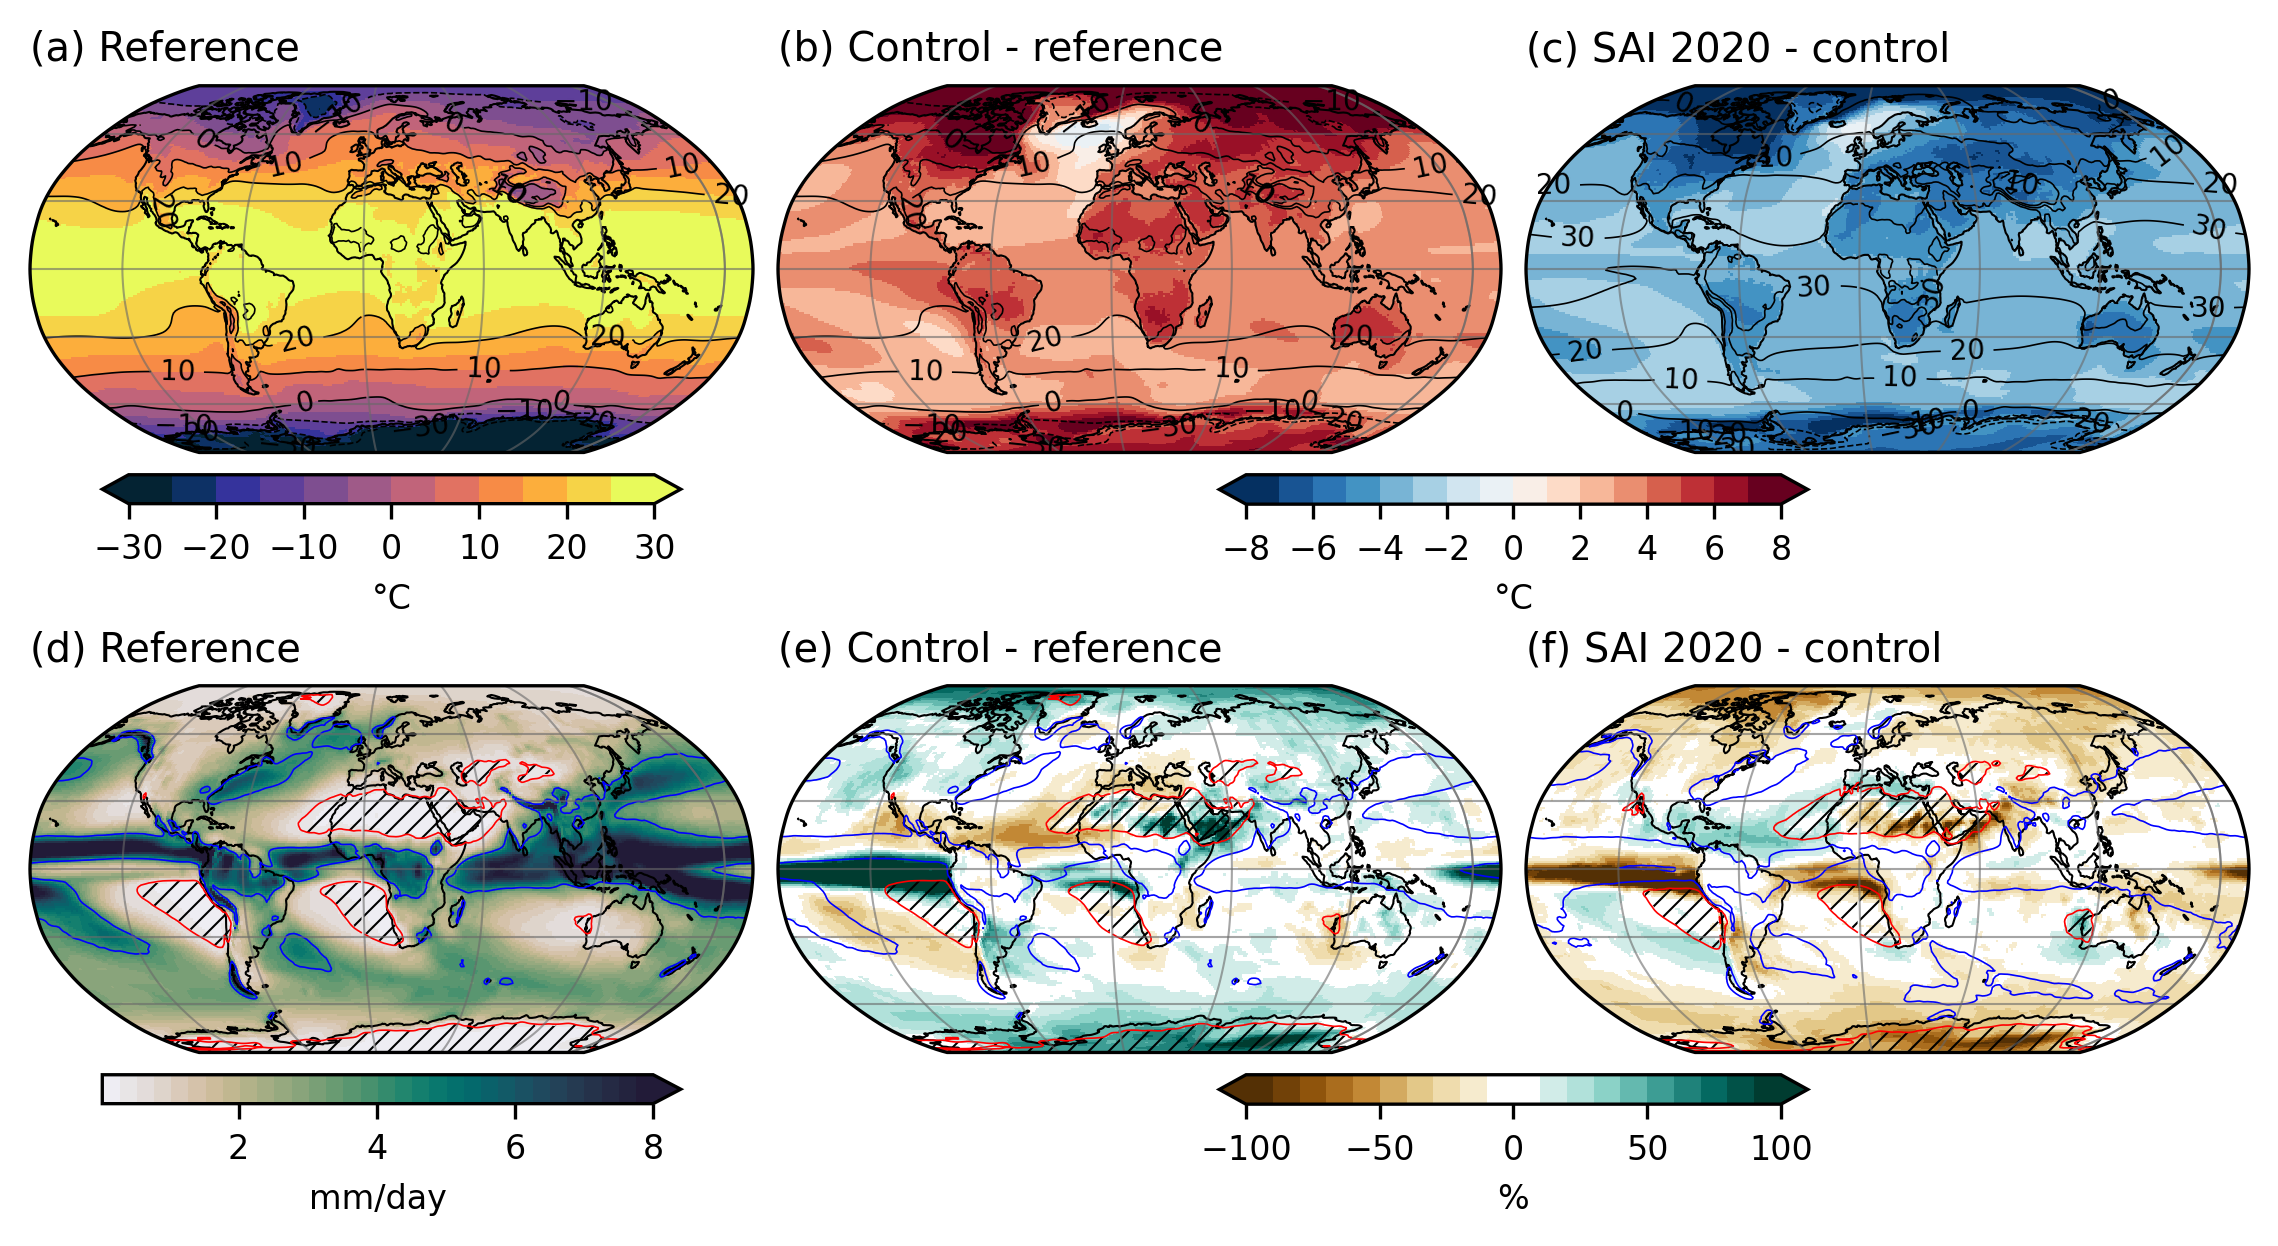

In [37]:
scens = ['C_ref', 'C_cntref', 'C_20cnt']
scens_t = ['C_ref', 'C_ref', 'C_cnt']
labels = np.asarray([['(a) Reference', '(b) Control - reference', '(c) SAI 2020 - control'], 
                     ['(d) Reference', '(e) Control - reference', '(f) SAI 2020 - control']])

fig, ax = plt.subplots(2,3, figsize=imgsize3, layout='constrained', subplot_kw={'projection':ccrs.Robinson(central_longitude=14)})

yoink = mpl.colormaps['RdBu_r'].resampled(16)
newcolors = yoink(np.linspace(0,1,16))
# white = np.array([1, 1, 1, 1])
# newcolors[7:9,:] = white
newcmap = colors.ListedColormap(newcolors)

yoink = mpl.colormaps['BrBG'].resampled(20)
newcolors = yoink(np.linspace(0,1,20))
white = np.array([1, 1, 1, 1])
newcolors[9:11,:] = white
newcmap2 = colors.ListedColormap(newcolors)

for j in range(3):
    for i in range(2):  
        if i == 0:
            if j == 0:
                ax[i,j].coastlines(resolution='110m', linewidth=0.5)
                
                ima = trefht_d[scens[j]].plot(ax=ax[i,j], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('cmo.thermal', 12), vmin=-30, vmax=30, add_colorbar=False)
                gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')
            
                plot = trefht[scens_t[j]].plot.contour(ax=ax[i,j], transform=ccrs.PlateCarree(), colors='k', linewidths=0.4, vmin=-30, vmax=30, levels=7, kwargs=dict(inline=True))
                ax[i,j].clabel(plot, fontsize='small', inline_spacing=1)
            
                ax[i,j].set_title(labels[i,j], loc='left')
            else:
                ax[i,j].coastlines(resolution='110m', linewidth=0.5)
                
                imb = trefht_d[scens[j]].plot(ax=ax[i,j], transform=ccrs.PlateCarree(), cmap=newcmap, vmin=-8, vmax=8, add_colorbar=False)
                gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')
            
                plot = trefht[scens_t[j]].plot.contour(ax=ax[i,j], transform=ccrs.PlateCarree(), colors='k', linewidths=0.4, vmin=-30, vmax=30, levels=7, kwargs=dict(inline=True))
                ax[i,j].clabel(plot, fontsize='small', inline_spacing=1)
            
                ax[i,j].set_title(labels[i,j], loc='left')
        else:
            if j == 0:
                ax[i,j].coastlines(resolution='110m', linewidth=0.5)

                imc = prect_d[scens[j]].plot(ax=ax[i,j], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('cmo.rain',32), vmax=8, add_colorbar=False)
                gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')
            
                plota = prect[scens_t[j]].plot.contour(ax=ax[i,j], transform=ccrs.PlateCarree(), colors=['red','b'], linewidths=0.4, levels=[0.5,4], kwargs=dict(inline=True))
            
                thresh = xr.where(prect[scens_t[j]] < 0.5, True, np.nan, keep_attrs=True)
                plotb = xr.plot.contourf(darray=thresh, ax=ax[i,j], transform=ccrs.PlateCarree(), hatches=['/////'], colors=None, alpha=0., add_colorbar=False)
                
                ax[i,j].set_title(labels[i,j], loc='left')
            else:
                ax[i,j].coastlines(resolution='110m', linewidth=0.5)
    
                imd = prect_d[scens[j]].plot(ax=ax[i,j], transform=ccrs.PlateCarree(), cmap=newcmap2, vmin=-100, vmax=100, add_colorbar=False)
                gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')
            
                plota = prect[scens_t[j]].plot.contour(ax=ax[i,j], transform=ccrs.PlateCarree(), colors=['red','b'], linewidths=0.4, levels=[0.5,4], kwargs=dict(inline=True))
            
                thresh = xr.where(prect[scens_t[j]] < 0.5, True, np.nan, keep_attrs=True)
                plotb = xr.plot.contourf(darray=thresh, ax=ax[i,j], transform=ccrs.PlateCarree(), hatches=['/////'], colors=None, alpha=0., add_colorbar=False)
                
                ax[i,j].set_title(labels[i,j], loc='left')

plt.colorbar(ima, ax=ax[0,0], shrink=0.8, location='bottom', label='°C', extend='both', ticks=[-30,-20,-10,0,10,20,30])
plt.colorbar(imb, ax=ax[0,1:], shrink=0.4, location='bottom', label='°C', extend='both', ticks=[-8,-6,-4,-2,0,2,4,6,8])
plt.colorbar(imc, ax=ax[1,0], shrink=0.8, location='bottom', label='mm/day', extend='max', ticks=[0,2,4,6,8])
plt.colorbar(imd, ax=ax[1,1:], shrink=0.4, location='bottom', label='%', extend='both', ticks=[-100,-50,0,50,100])


if save == True: plt.savefig(savepath+'CAM_scens.png', bbox_inches = 'tight')# plt.savefig(savepath+'CAM_scens.eps', bbox_inches = 'tight');


# Zonal wind and potential temperature

## Data

In [38]:
### CAM
scenarios['Control'].get_atm_var2('U')
scenarios['SAI 2020'].get_atm_var2('U')

scenarios['Control']['U']['plev'] = scenarios['Control']['U']['plev']/100
scenarios['SAI 2020']['U']['plev'] = scenarios['SAI 2020']['U']['plev']/100

scenarios['Control'].get_atm_var2('T')
scenarios['SAI 2020'].get_atm_var2('T')

scenarios['Control']['T']['theta'] = theta(scenarios['Control']['T'])
scenarios['SAI 2020']['T']['theta'] = theta(scenarios['SAI 2020']['T'])
scenarios['Control']['T']['plev'] = scenarios['Control']['T']['plev']/100
scenarios['SAI 2020']['T']['plev'] = scenarios['SAI 2020']['T']['plev']/100

In [39]:
### WACCM 
uW_ref = CMIP6_get_var('ua')
uW_20 = GLENS2_get_var('U')
uW_ref['plev'] = uW_ref['plev']/100
uW_20['plev'] = uW_20['plev']/100

thW_ref = CMIP6_get_var('ta')
thW_20 = GLENS2_get_var('T')

thW_ref['theta'] = theta2(thW_ref, 'ta')
thW_20['theta'] = theta2(thW_20, 'T')

thW_ref['plev'] = thW_ref['plev']/100
thW_20['plev'] = thW_20['plev']/100

In [40]:
u = {
    'C_ref':time_mean(scenarios['Control']['U'],slice_i)['U'].mean(dim='lon'),
    'C_cnt':time_mean(scenarios['Control']['U'],slice_f)['U'].mean(dim='lon'),
    'C_20':time_mean(scenarios['SAI 2020']['U'],slice_f)['U'].mean(dim='lon'),

    'CJJA_ref':time_mean(scenarios['Control']['U'].sel(time=scenarios['Control']['U'].time.dt.season=='JJA'),slice_i)['U'].mean(dim='lon'),
    'CJJA_20':time_mean(scenarios['SAI 2020']['U'].sel(time=scenarios['SAI 2020']['U'].time.dt.season=='JJA'),slice_f)['U'].mean(dim='lon'),

    'CDJF_ref':time_mean(scenarios['Control']['U'].sel(time=scenarios['Control']['U'].time.dt.season=='DJF'),slice_i)['U'].mean(dim='lon'),
    'CDJF_20':time_mean(scenarios['SAI 2020']['U'].sel(time=scenarios['SAI 2020']['U'].time.dt.season=='DJF'),slice_f)['U'].mean(dim='lon'),

    'W_ref':time_mean3(uW_ref,slice_i,'ua').mean(dim='lon'),
    'W_cnt':time_mean3(uW_ref,slice_f,'ua').mean(dim='lon'),
    'W_20':time_mean3(uW_20,slice_f,'U').mean(dim='lon'),

    'WJJA_ref':time_mean3(uW_ref.sel(time=uW_ref.time.dt.season=='JJA'),slice_i,'ua').mean(dim='lon'),
    'WJJA_20':time_mean3(uW_20.sel(time=uW_20.time.dt.season=='JJA'),slice_f,'U').mean(dim='lon'),

    'WDJF_ref':time_mean3(uW_ref.sel(time=uW_ref.time.dt.season=='DJF'),slice_i,'ua').mean(dim='lon'),
    'WDJF_20':time_mean3(uW_20.sel(time=uW_20.time.dt.season=='DJF'),slice_f,'U').mean(dim='lon')
}


In [41]:
th = {
    'C_ref':time_mean(scenarios['Control']['T'],slice_i)['theta'].mean(dim='lon'),
    'C_ref':time_mean(scenarios['Control']['T'],slice_f)['theta'].mean(dim='lon'),
    'C_20':time_mean(scenarios['SAI 2020']['T'],slice_f)['theta'].mean(dim='lon'),

    'CJJA_ref':time_mean(scenarios['Control']['T'].sel(time=scenarios['Control']['T'].time.dt.season=='JJA'),slice_i)['theta'].mean(dim='lon'),
    'CJJA_20':time_mean(scenarios['SAI 2020']['T'].sel(time=scenarios['SAI 2020']['T'].time.dt.season=='JJA'),slice_f)['theta'].mean(dim='lon'),

    'CDJF_ref':time_mean(scenarios['Control']['T'].sel(time=scenarios['Control']['T'].time.dt.season=='DJF'),slice_i)['theta'].mean(dim='lon'),
    'CDJF_20':time_mean(scenarios['SAI 2020']['T'].sel(time=scenarios['SAI 2020']['T'].time.dt.season=='DJF'),slice_f)['theta'].mean(dim='lon'),

    'W_ref':time_mean3(thW_ref,slice_i,'theta').mean(dim='lon'),
    'W_ref':time_mean3(thW_ref,slice_f,'theta').mean(dim='lon'),
    'W_20':time_mean3(thW_20,slice_f,'theta').mean(dim='lon'),

    'WJJA_ref':time_mean3(thW_ref.sel(time=thW_ref.time.dt.season=='JJA'),slice_i,'theta').mean(dim='lon'),
    'WJJA_20':time_mean3(thW_20.sel(time=thW_20.time.dt.season=='JJA'),slice_f,'theta').mean(dim='lon'),

    'WDJF_ref':time_mean3(thW_ref.sel(time=thW_ref.time.dt.season=='DJF'),slice_i,'theta').mean(dim='lon'),
    'WDJF_20':time_mean3(thW_20.sel(time=thW_20.time.dt.season=='DJF'),slice_f,'theta').mean(dim='lon')
}


In [42]:
u_d = {}

for i in range(3):
    u_d[C_ref[i]] = u[C_ref[i]].compute()
    u_d[W_ref[i]] = u[W_ref[i]].compute()    
    u_d[C_20ref[i]] = (u[C_20[i]] - u[C_ref[i]]).compute()
    u_d[W_20ref[i]] = (u[W_20[i]] - u[W_ref[i]]).compute()
    
u_d['CWref'] = u['C_ref'] - u['W_ref']
u_d['CWcnt'] = u['C_cnt'] - u['W_cnt']
u_d['CW20'] = u['C_20'] - u['W_20']

In [43]:
th_d = {}

for i in range(3):
    th_d[C_ref[i]] = th[C_ref[i]].compute()
    th_d[W_ref[i]] = th[W_ref[i]].compute()    
    th_d[C_20ref[i]] = (th[C_20[i]] - th[C_ref[i]]).compute()
    th_d[W_20ref[i]] = (th[W_20[i]] - th[W_ref[i]]).compute()

th_d['CWref'] = th['C_ref'] - th['W_ref']
th_d['CWcnt'] = th['C_cnt'] - th['W_cnt']
th_d['CW20'] = th['C_20'] - th['W_20']


## Plots

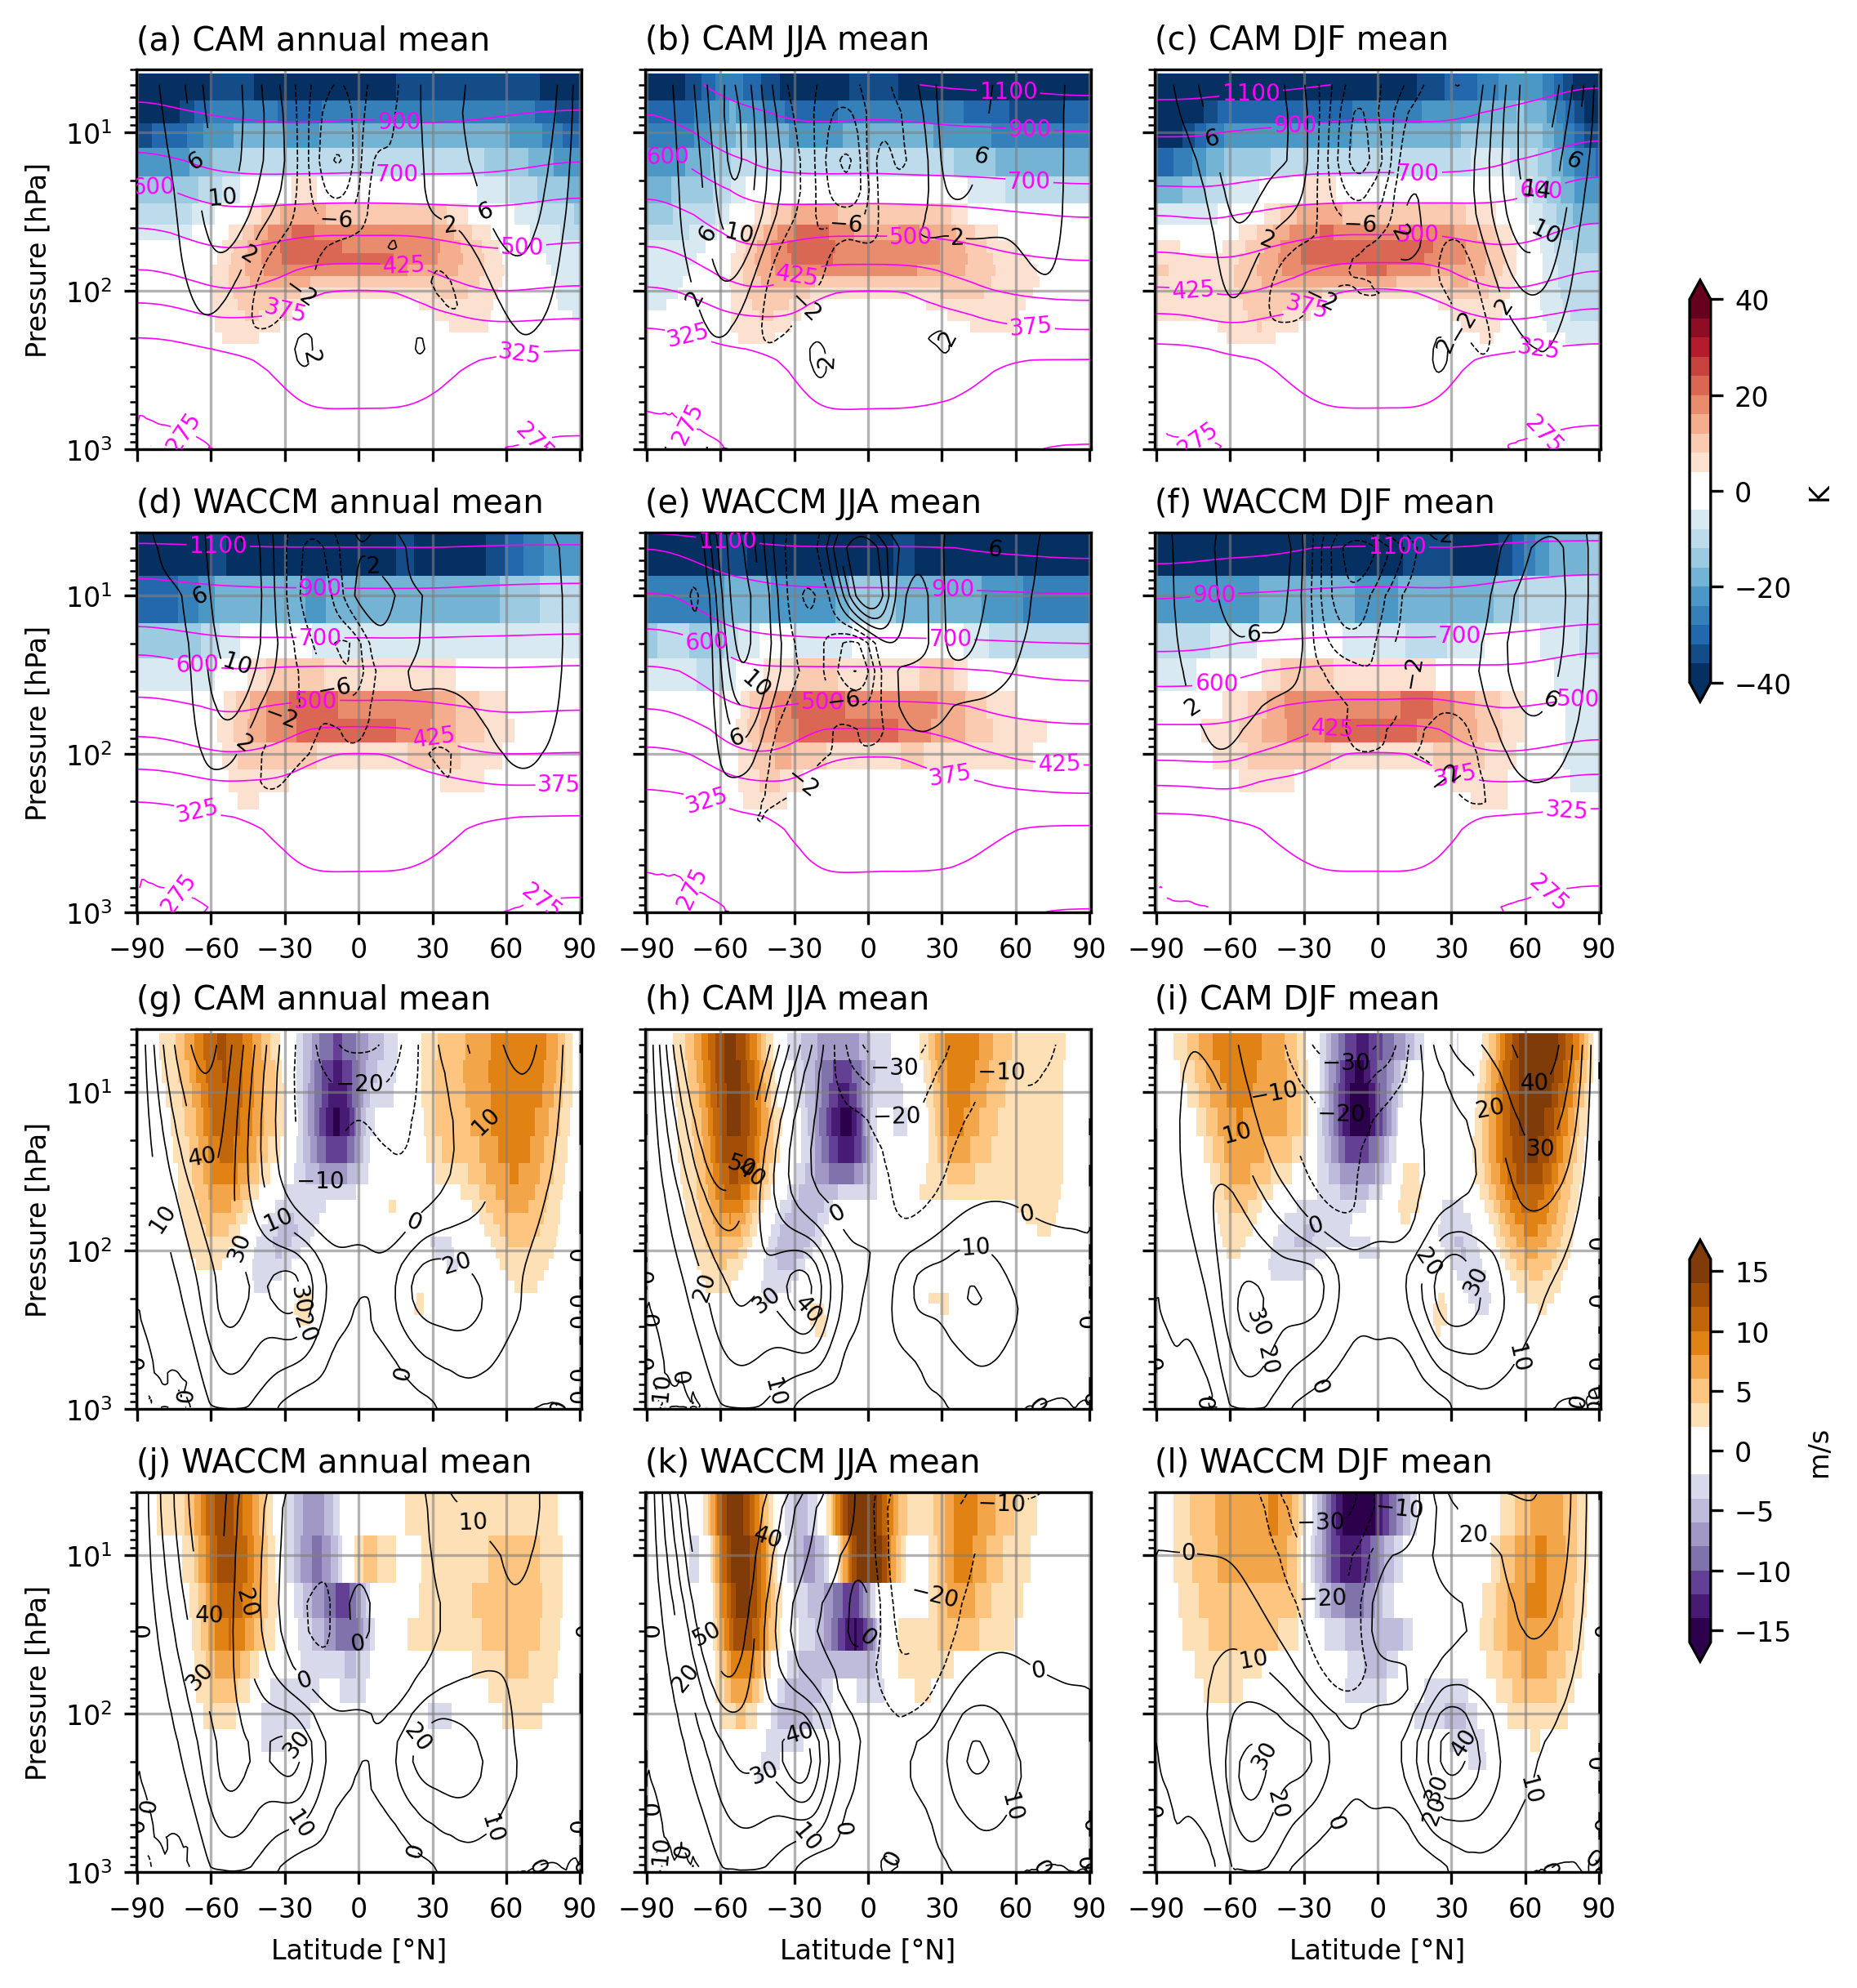

In [44]:
scens = np.stack((C_20ref, W_20ref))
refs = np.stack((C_ref, W_ref))
labels = np.asarray([['(a) CAM annual mean', '(b) CAM JJA mean', '(c) CAM DJF mean'],['(d) WACCM annual mean', '(e) WACCM JJA mean', '(f) WACCM DJF mean'],['(g) CAM annual mean', '(h) CAM JJA mean', '(i) CAM DJF mean'],['(j) WACCM annual mean', '(k) WACCM JJA mean', '(l) WACCM DJF mean']])

fig, ax = plt.subplots(4,3, figsize=imgsize6, layout='constrained')

yoink = mpl.colormaps['RdBu_r'].resampled(20)
newcolors = yoink(np.linspace(0,1,20))
white = np.array([1, 1, 1, 1])
newcolors[9:11,:] = white
newcmap = colors.ListedColormap(newcolors)

yoink = mpl.colormaps['PuOr_r'].resampled(16)
newcolors = yoink(np.linspace(0,1,16))
white = np.array([1, 1, 1, 1])
newcolors[7:9,:] = white
newcmap2 = colors.ListedColormap(newcolors)

for j in (0,1):
    for i in range(3):    
        im = th_d[scens[j,i]].plot(ax=ax[j,i], x='lat', y='plev', cmap=newcmap, vmin=-40, vmax=40, add_colorbar=False)
        
        plota = th_d[refs[j,i]].plot.contour(ax=ax[j,i], x='lat', y='plev', colors='magenta', linewidths=0.4, levels=[275,325,375,425,500,600,700,900,1100], kwargs=dict(inline=True))
        ax[j,i].clabel(plota, fontsize='small', inline_spacing=1)

        plotb = u_d[scens[j,i]].plot.contour(ax=ax[j,i], x='lat', y='plev', colors='k', linewidths=0.4, vmin=-14, vmax=14, levels=8, kwargs=dict(inline=True))
        ax[j,i].clabel(plotb, fontsize='small', inline_spacing=1)

        ax[j,i].set_title(labels[j,i], loc='left')

        ax[j,i].set_xlabel(None)
        ax[j,i].set_ylabel(None)
        
        ax[j,i].set_xticks(np.arange(-90,91,30))
        
        ax[j,i].invert_yaxis()
        ax[j,i].set_yscale('log')
        ax[j,i].grid(color='gray', alpha=0.6)
        ax[j,i].set_ylim(10**3,4)

        if ax[j,i] in ax[:,1:].flatten():
            ax[j,i].set_yticklabels([])
        
        if ax[j,i] in ax[:,0].flatten():
            ax[j,i].set_ylabel('Pressure [hPa]')
        
        if ax[j,i] in ax[0,:].flatten():
            ax[j,i].set_xticklabels([])
        
        if ax[j,i] in ax[1,:].flatten():
            ax[j,i].set_xlabel(None)


    ax[j,0].set_ylabel('Pressure [hPa]')

# ax[1,0].set_xlabel('Latitude [°N]')
# ax[1,1].set_xlabel('Latitude [°N]')
# ax[1,2].set_xlabel('Latitude [°N]')

plt.colorbar(im, ax=ax[:2,:], shrink=0.5, location='right', label='K', extend='both')

for j in (2,3):
    for i in range(3):    
        im = u_d[scens[j-2,i]].plot(ax=ax[j,i], x='lat', y='plev', cmap=newcmap2, vmin=-16, vmax=16, add_colorbar=False)
        
        plota = u_d[refs[j-2,i]].plot.contour(ax=ax[j,i], x='lat', y='plev', colors='k', linewidths=0.4, vmin=-50, vmax=50, levels=11, kwargs=dict(inline=True))
        ax[j,i].clabel(plota, fontsize='small', inline_spacing=1)

        ax[j,i].set_title(labels[j,i], loc='left')

        ax[j,i].set_xlabel(None)
        ax[j,i].set_ylabel(None)
        
        ax[j,i].set_xticks(np.arange(-90,91,30))
        
        ax[j,i].invert_yaxis()
        ax[j,i].set_yscale('log')
        ax[j,i].grid(color='gray', alpha=0.6)
        ax[j,i].set_ylim(10**3,4)

        if ax[j,i] in ax[:,1:].flatten():
            ax[j,i].set_yticklabels([])
        
        if ax[j,i] in ax[:,0].flatten():
            ax[j,i].set_ylabel('Pressure [hPa]')
        
        if ax[j,i] in ax[2,:].flatten():
            ax[j,i].set_xticklabels([])
        
        if ax[j,i] in ax[3,:].flatten():
            ax[j,i].set_xlabel('Latitude [°N]')
            # ax[j,i].set_xticklabels([])


    ax[j,0].set_ylabel('Pressure [hPa]')

ax[3,0].set_xlabel('Latitude [°N]')
ax[3,1].set_xlabel('Latitude [°N]')
ax[3,2].set_xlabel('Latitude [°N]')

plt.colorbar(im, ax=ax[2:,:], shrink=0.5, location='right', label='m/s', extend='both')


if save == True: plt.savefig(savepath+'th_U_full.png', bbox_inches = 'tight')#plt.savefig(savepath+'th_U_full.eps', bbox_inches = 'tight'); 


In [ ]:
## WACCM minus CAM th and U

In [45]:
scens = CW
scens_t = ['W_ref', 'W_cnt', 'W_20']
labels = np.asarray([['(a) Reference $\Delta\theta$', '(b) Control $\Delta\theta$', '(c) SAI 2020 $\Delta\theta$'], 
                     ['(d) Reference $\Delta$U', '(e) Control $\Delta$U', '(f) SAI 2020 $\Delta$U']])


fig, ax = plt.subplots(2,3, figsize=imgsize4, layout='constrained')

yoink = mpl.colormaps['RdBu_r'].resampled(20)
newcolors = yoink(np.linspace(0,1,20))
white = np.array([1, 1, 1, 1])
newcolors[9:11,:] = white
newcmap = colors.ListedColormap(newcolors)

yoink = mpl.colormaps['PuOr_r'].resampled(16)
newcolors = yoink(np.linspace(0,1,16))
white = np.array([1, 1, 1, 1])
newcolors[7:9,:] = white
newcmap2 = colors.ListedColormap(newcolors)


for j in range(3):
    for i in range(2):  
        if i == 0:       
            ima = th_d[scens[i,j]].plot(ax=ax[i,j], x='lat', y='plev', cmap=newcmap, vmin=-40, vmax=40, add_colorbar=False)
             
            plot = th[scens_t[j]].plot.contour(ax=ax[i,j], colors='k', linewidths=0.4, vmin=-30, vmax=30, levels=7, kwargs=dict(inline=True))
            ax[i,j].clabel(plot, fontsize='small', inline_spacing=1)
        
            ax[j,i].set_title(labels[i,j], loc='left')

            ax[j,i].set_xlabel(None)
            ax[j,i].set_ylabel(None)
            
            ax[j,i].set_xticks(np.arange(-90,91,30))
            
            ax[j,i].invert_yaxis()
            ax[j,i].set_yscale('log')
            ax[j,i].grid(color='gray', alpha=0.6)
            ax[j,i].set_ylim(10**3,4)

            if ax[j,i] == ax[0,1:].flatten():
                ax[j,i].set_yticklabels([])
            
            if ax[j,i] in ax[0,0].flatten():
                ax[j,i].set_ylabel('Pressure [hPa]')
            
            ax[j,i].set_xticklabels([])
            
        if i == 1:
            imb = u_d[scens[i,j]].plot(ax=ax[i,j], x='lat', y='plev', cmap=newcmap2, vmin=-16, vmax=16, add_colorbar=False)
            gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')
        
            plota = u_d[scens_t[j]].plot.contour(ax=ax[i,j], x='lat', y='plev', colors='k', linewidths=0.4, vmin=-50, vmax=50, levels=11, kwargs=dict(inline=True))
            ax[j,i].clabel(plota, fontsize='small', inline_spacing=1) 

            ax[i,j].set_title(labels[i,j], loc='left')

            ax[j,i].set_xlabel(None)
            ax[j,i].set_ylabel(None)
            
            ax[j,i].set_xticks(np.arange(-90,91,30))
            
            ax[j,i].invert_yaxis()
            ax[j,i].set_yscale('log')
            ax[j,i].grid(color='gray', alpha=0.6)
            ax[j,i].set_ylim(10**3,4)

            if ax[j,i] in ax[1,1:].flatten():
                ax[j,i].set_yticklabels([])
            
            if ax[j,i] in ax[1,0].flatten():
                ax[j,i].set_ylabel('Pressure [hPa]')

    ax[1,j].set_xlabel('Latitude [°N]')


plt.colorbar(ima, ax=ax[0,:], shrink=0.8, location='right', label='K', extend='both')#, ticks=[-30,-20,-10,0,10,20,30])
plt.colorbar(imb, ax=ax[1,:], shrink=0.8, location='right', label='m/s', extend='both')#, ticks=[-8,-4,0,4,8])


if save == True: plt.savefig(savepath+'CAM_WACCM_thU.png', bbox_inches = 'tight')#plt.savefig(savepath+'CAM_WACCM.eps', bbox_inches = 'tight');
